
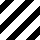
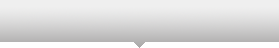
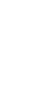
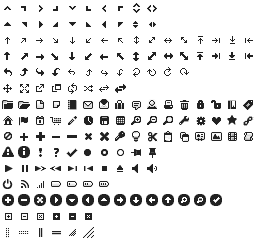
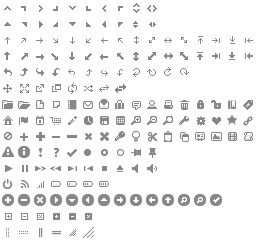
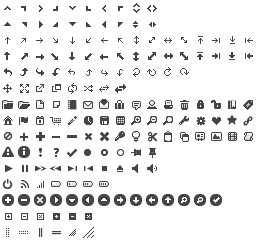
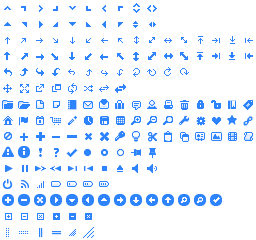
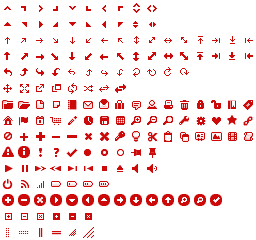
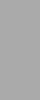
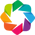
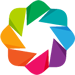
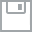
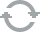
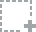
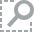
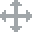
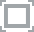
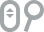

In [1]:
from __future__ import division
import glob
from datetime import datetime, timedelta
import json
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pandas as pd

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()
from castra import Castra

from mpl_toolkits.basemap import Basemap

from bokeh.plotting import figure, show, output_notebook
output_notebook()

import statsmodels.api as sm
import folium

import seaborn as sns

%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

In [2]:
date_parser = lambda x: datetime.strptime(x, '%Y%m%d')

CATEGORIES = ['Station', 'Komponente','TYPE_OF_AREA', 'TYPE_OF_STATION', 'TYPE_OF_DATA', 'Lieferung']
ID_VARS = list(CATEGORIES) + ['Datum']
VALUES = ['Wert{:02d}'.format(i) for i in range(1, 25)]

CATEGORIES = []  # pandas 0.17.X has some problems with categories, let's leave them out for now.

date_format = "%Y%m%d %H"

def create_dataframe():
    df = dd.read_csv('data/DE*.csv', encoding='latin1', sep=';', quotechar="'", na_values=['', '-999', '-111'],
                     parse_dates=['Datum'], date_parser=date_parser)

    df = df.compute()
    print('Make categories...')
    for c in CATEGORIES:
        df[c] = df[c].astype('category')

    print('Melting values...')
    df = pd.melt(df, id_vars=ID_VARS, value_vars=VALUES, var_name='hour', value_name='value')
    print('Converting hour column...')
    hours = df.hour.map(lambda x: x[4:]).convert_objects(convert_numeric=True) - 1
    hours = pd.to_timedelta(hours, unit='h')
    print('Applying hour to date column...')
    df['date'] = df.Datum + hours
    df = df.drop(['Datum', 'hour'], axis=1)
    print('Setting index...')
    df = df.set_index('date')
    return df

def get_daskframe(path='stickoxide.castra'):
    if not os.path.exists(path):
        print('Castra path "%s" not found, recreating...' % path)
        df = create_dataframe()
        print('Writing castra file...')
        c = Castra(path, template=df, categories=bool(len(CATEGORIES)))
        c.extend(df)
        return c.to_dask()
    c = Castra(path=path)
    return c.to_dask()

dfk = get_daskframe()
df = dfk.compute()
df.head()

[########################################] | 100% Completed |  3min 26.1s


Station        Komponente           TYPE_OF_AREA TYPE_OF_STATION  \
date                                                                           
2009-01-01  DEBB007  Stickstoffdioxid  vorstädtisches Gebiet     Hintergrund   
2009-01-01  DEHE094  Stickstoffdioxid     städtisches Gebiet         Verkehr   
2009-01-01  DEHH008  Stickstoffdioxid     städtisches Gebiet     Hintergrund   
2009-01-01  DEHH015  Stickstoffdioxid     städtisches Gebiet       Industrie   
2009-01-01  DEHH016  Stickstoffdioxid     städtisches Gebiet       Industrie   

           TYPE_OF_DATA Lieferung  value  
date                                      
2009-01-01            H         Y  23.20  
2009-01-01            H         Y  38.00  
2009-01-01            H         Y  36.25  
2009-01-01            H         Y  30.50  
2009-01-01            H         Y    NaN

In [3]:
german_date_parser = lambda x: datetime.strptime(x, '%d.%m.%Y')
stations = pd.read_csv('data/station_All.csv', encoding='latin1', sep=';', quotechar='"', skiprows=1, parse_dates=[4, 5], date_parser=german_date_parser)
stations[u'Aktivitätsperiode: bis'] = stations[u'Aktivitätsperiode: bis'].convert_objects(convert_dates='coerce')
stations[u'lng'] = stations[u'Länge dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations[u'lat'] = stations[u'Breite dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations['height'] = stations[u'Höhe'].convert_objects(convert_numeric=True)
stations['ags'] = stations[u'Amtlicher Gemeindeschlüssel (AGS)'].dropna().apply(lambda x: '{:0>5d}'.format(int(str(x)[:5])))
stations = stations.rename(columns={'Stationscode': 'Station'})
stations.head()

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Station            Stationsname        Kategorie Synonym Aktiv seit   \
0  DEBB001        Burg (Spreewald)  Luftmessstation    BUCH  1993-01-01   
1  DEBB002        Brandenburg-Nord  Luftmessstation    BRGU  1991-02-01   
2  DEBB003  Brandenburg a.d. Havel  Luftmessstation    BRPI  1991-03-01   
3  DEBB004             Cottbus-LUA  Luftmessstation    COUA  1991-01-01   
4  DEBB005   Cottbus-City (-Mitte)  Luftmessstation    COCY  1991-01-01   

  Aktivitätsperiode: von  Aktivitätsperiode: bis Verlegt  \
0              1993-01-01             2003-05-19    nein   
1              1991-02-01             1994-06-30    nein   
2              1991-03-01             2001-07-06    nein   
3              1991-01-01             2003-12-31    nein   
4              1991-01-01             1997-03-31    nein   

                 Straße   Nr    PLZ          Ort Länge dezimal Breite dezimal  \
0           Bahnhofstr.    9   3096         Burg     14,141703      51,837590   
1       GutsMuthsstraße  NaN  14470  Brandenburg     12,560379      52,420960   
2  Gertrud-Pieter-Platz    9  14770  Brandenburg     12,544441      52,412114   
3           Am Nordrand   45   3044      Cottbus     14,327692      51,778045   
4  Karl-Liebknecht-Str.  136   3046      Cottbus     14,331685      51,757900   

   Höhe Stationsumgebung (EoI) Art der Station (EoI)  Einwohnerzahl (EoI)  \
0    54  vorstädtisches Gebiet           Hintergrund                  NaN   
1    31  vorstädtisches Gebiet           Hintergrund                  NaN   
2    33     städtisches Gebiet               Verkehr                  NaN   
3    68  vorstädtisches Gebiet           Hintergrund                  NaN   
4    74     städtisches Gebiet           Hintergrund                  NaN   

  Abstand zur Straße (EoI)                          Bemerkung (EoI)  \
0                 >10-50 m  eingezäuntes Gelände, aber gut sichtbar   
1                      NaN                                      NaN   
2                 >10-50 m                                      NaN   
3                      NaN                                      NaN   
4                 >10-50 m                                      NaN   

  Lokaler Code EMEP-Code O3-Klasse aus UBA FE NO/NO2-Klasse aus UBA FE  \
0          213       NaN                   ST                      NaN   
1          106        No                  NaN                      NaN   
2          114        No                   ST                       ST   
3          201        No                  NaN                      NaN   
4          212        No                  NaN                      NaN   

                                Bemerkung des UBA(1) Bemerkung des UBA(2)  \
0                                                NaN                  NaN   
1                                                NaN                  NaN   
2  mitgeteilte Inbetriebnahme später als in Jahre...                  NaN   
3                                                NaN                  NaN   
4                                                NaN                  NaN   

                        Bemerkung des Netzbetreibers AEI-Station AEI-von  \
0                                                NaN        nein     NaN   
1                                                NaN        nein     NaN   
2                                                NaN        nein     NaN   
3  nach Schließung teilweise Staubmesspunkt (Ruß,...        nein     NaN   
4                                                NaN        nein     NaN   

  AEI-bis ersetzt AEI-Station  Amtlicher Gemeindeschlüssel (AGS)  \
0     NaN                 NaN                           12071032   
1     NaN                 NaN                           12051000   
2     NaN                 NaN                           12051000   
3     NaN                 NaN                           12052000   
4     NaN                 NaN                           12052000   

              Gemeindenamen  \
0        

In [4]:
len(stations)

1780

In [5]:
germany_bbox = {
  'lon': 10.45415,
  'lat': 51.164181,
  'll_lon': 5.86624,
  'll_lat': 47.27021,
  'ur_lon': 15.04205,
  'ur_lat': 55.05814
}

def shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def plot_map(df, vals='value', cmap='cool', diverging=False, bbox=germany_bbox):
    if diverging:
        vmin = df[vals].min()
        vmax = df[vals].max()
        midrange = 1 - vmax / (vmax + abs(vmin))
        cmap = shifted_color_map(matplotlib.cm.get_cmap(cmap), midpoint=midrange)
        
    markersize = 40
    markertype = 'o'  # pixel
    markercolor = '#325CA9'  # blue
    if vals is not None:
        markercolor = df[vals].as_matrix()
    markeralpha = .75 #  a bit of transparency

    fig = plt.figure(figsize=(10,16))
    m = Basemap(
      projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
      llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
      urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'],
      resolution='l'
    )
    m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
    x, y = m(df.lng.as_matrix(), df.lat.as_matrix())
    m.drawcoastlines()
    m.drawcountries()
    m.scatter(x, y, markersize, marker=markertype,  cmap=cmap, c=markercolor, alpha=markeralpha)
    m.colorbar()
    return m


In [6]:
# Span of dataset: 01.01.2009 - 30.09.2015
df.reset_index().date.describe()

count                26156688
unique                  61344
top       2009-01-22 20:00:00
freq                      448
first     2009-01-01 00:00:00
last      2015-12-31 23:00:00
Name: date, dtype: object

In [7]:
df.Komponente.value_counts()

Stickstoffdioxid    26156688
Name: Komponente, dtype: int64

In [8]:
df.TYPE_OF_AREA.value_counts()

städtisches Gebiet       15588696
vorstädtisches Gebiet     5346432
ländliches Gebiet         2138256
ländlich regional         1700136
ländlich stadtnah          999000
ländlich abgelegen         384168
Name: TYPE_OF_AREA, dtype: int64

In [9]:
df.TYPE_OF_STATION.value_counts()

Hintergrund    15836352
Verkehr         8786040
Industrie       1534296
Name: TYPE_OF_STATION, dtype: int64

In [10]:
df.TYPE_OF_DATA.value_counts()

# S = Stundendaten
# H = Halbstündlich
# T = Tagesdaten

S    17693064
H     8200680
T      262944
Name: TYPE_OF_DATA, dtype: int64

## Map of all stations coloured by their median measurement 2015

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


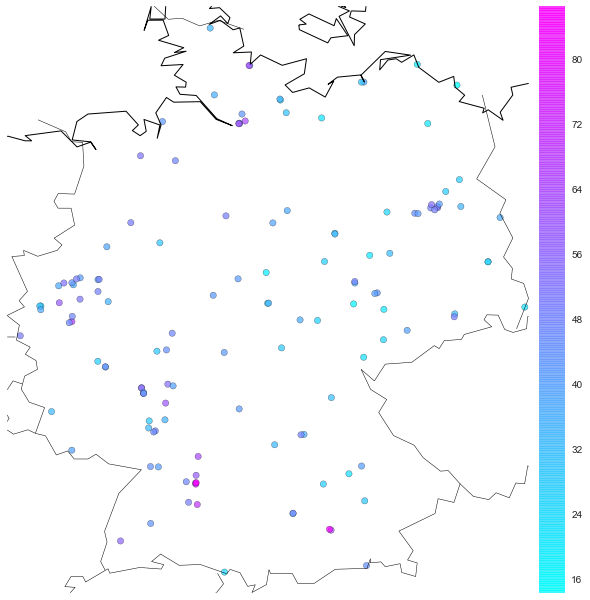

In [11]:
filtered = df[(df.index.year == 2015) & (df.TYPE_OF_STATION == 'Verkehr')]
filtered = filtered.groupby('Station')
filtered = filtered.value.mean().reset_index()
filtered = filtered.merge(stations, on='Station')
plot_map(filtered, 'value')

## All stations with their 2015 mean value greater than 40.

That means that half of all measurements in 2015 were greater than 50!

In [12]:
filtered[filtered.value > 40].sort_index(by='value', ascending=False)

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


Station      value                          Stationsname  \
20   DEBW118  86.545635            Stuttgart Am Neckartor (S)   
39   DEBY115  83.602770              München/Landshuter Allee   
18   DEBW116  76.781338      Stuttgart Hohenheimer Straße (S)   
25   DEBW147  69.578528        Reutlingen Lederstraße Ost (S)   
87   DENW211  66.280449                Köln Clevischer Ring 3   
109  DESH052  64.132713               Kiel-Theodor-Heuss-Ring   
26   DEBW152  63.607577  Heilbronn Weinsberger Straße Ost (S)   
34   DEBY037  63.550944                       München/Stachus   
58   DEHH068  62.880004                 Hamburg Habichtstraße   
59   DEHH070  61.886373  Hamburg Max-Brauer-Allee II (Straße)   
17   DEBW099  61.377524          Stuttgart_Arnulf-Klett-Platz   
47   DEHE040  60.536895                 Darmstadt-Hügelstraße   
74   DENW082  58.911818            Düsseldorf Corneliusstraße   
19   DEBW117  57.845249       Ludwigsburg Friedrichstraße (S)   
94   DERP010  56.603178                    Mainz-Parcusstraße   
22   DEBW122  55.706564        Freiburg Schwarzwaldstraße (V)   
54   DEHE112  53.480666          Wiesbaden-Schiersteiner Str.   
13   DEBE067  52.973237                     B Hardenbergplatz   
46   DEHE037  52.796392                  Wiesbaden-Ringkirche   
48   DEHE041  52.751185               Frankfurt-Friedb.Ldstr.   
81   DENW188  52.580817       Oberhausen Mülheimer Straße 117   
71   DENI143  52.329650           Oldenburg Heiligengeistwall   
10   DEBE063  51.618675            B Neukölln-Silbersteinstr.   
11   DEBE064  51.526252          B Neukölln-Karl-Marx-Str. 76   
82   DENW189  51.477756                       Wuppertal Gathe   
85   DENW207  50.177560                  Aachen Wilhelmstraße   
67   DENI067  50.159570                     Osnabrück-Verkehr   
86   DENW208  49.887546  Gelsenkirchen Kurt-Schumacher-Straße   
24   DEBW136  49.710199               Tübingen Mühlstraße (S)   
56   DEHH026  49.376539              Hamburg Stresemannstraße   
120  DESN084  49.230857                      Dresden-Bergstr.   
80   DENW136  49.182419             Dortmund Brackeler Straße   
66   DENI048  49.131685                      Hannover Verkehr   
37   DEBY110  49.015706                   Augsburg/Karlstraße   
14   DEBE069  48.914547       B Mariendorf, Mariendorfer Damm   
127  DEST102  48.605196                  Halle/Paracelsusstr.   
78   DENW133  48.522062             Hagen Graf-von-Galen-Ring   
57   DEHH064  48.174256                 Hamburg Kieler Straße   
41   DEBY120  48.064358          Nürnberg/Von-der-Tann-Straße   
9    DEBE061  47.577187             B Steglitz-Schildhornstr.   
21   DEBW120  47.196880             Leonberg Grabenstraße (S)   
52   DEHE062  47.151997                Marburg-Univers.Straße   
43   DEHB006  47.141014                      Bremen Verkehr 1   
92   DENW355  47.006058      Leverkusen Gustav-Heinemann-Str.   
16   DEBW098  46.970439               Mannheim_Friedrichsring   
101  DERP041  46.348905             Ludwigshafen-Heinigstraße   
88   DENW212  46.343359                   Köln Turiner Straße   
51   DEHE061  44.938184                     Gießen-Westanlage   
102  DERP045  44.834192            Koblenz-Hohenfelder Straße   
3    DEBB054  44.615981                  Potsdam Zeppelinstr.   
15   DEBW080  44.573628      Karlsruhe_Reinhold-Frank-Strasse   
96   DERP012  44.529233                 Mainz-Große Langgasse   
42   DEBY121  44.377392            Oberaudorf/Inntal-Autobahn   
27   DEBW156  43.809701         Schramberg Oberndorfer Straße   
79   DENW134  43.451507               Essen Gladbecker Straße   
108  DESH030  42.703302                           Norderstedt   
115  DESN025  42.611622                         Leipzig-Mitte   
49   DEHE049  42.078544               Kassel-Fünffenster-Str.   
44   DEHB011  41.984117                    Cherbourger Straße   
40   DEBY119  41.812199                Würzburg/Stadtring Süd   
6    DEBB073  41.757824               Po

## Top 20 highest measurements in dataset

"DENW116" (Krefeld (Hafen), Luftmessstation, Geo: 51.342561, 6.670195):

A fire seems to be the cause:
http://feuerwehr-herscheid.de/eins%C3%A4tze/2012/krefeld-26-09-12/
https://www.derwesten.de/staedte/duisburg/loescharbeiten-in-duengemittelfabrik-werden-noch-tage-dauern-id7135294.html
https://www.derwesten.de/staedte/nachrichten-aus-wesel-hamminkeln-und-schermbeck/-id7133204.html

Despite reports, the values indicate that air pollution was at unhealthy levels!

Site of fire and site of detector:
https://www.bing.com/maps/#Y3A9NTEuMDAwMDAwfjkuMDAwMDAwJmx2bD01JnN0eT1yJndoZXJlMT01MSVDMiVCMDIwJzMzLjIlMjJOJTIwNiVDMiVCMDQwJzEyLjclMjJF


In [13]:
df.sort_index(by='value', ascending=False).head(20).reset_index().merge(stations[['Station', 'Ort']], on='Station')

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


date  Station        Komponente           TYPE_OF_AREA  \
0  2012-09-26 00:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
1  2012-09-26 05:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
2  2012-09-25 23:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
3  2012-09-26 01:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
4  2012-09-26 03:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
5  2012-09-26 04:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
6  2012-09-26 06:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
7  2012-09-27 02:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
8  2012-09-25 21:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
9  2012-09-27 01:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
10 2012-09-25 22:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
11 2012-09-26 07:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
12 2012-09-26 02:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
13 2012-09-26 23:00:00  DENW116  Stickstoffdioxid  vorstädtisches Gebiet   
14 2011-03-29 00:00:00  DEBW099  Stickstoffdioxid     städtisches Gebiet   
15 2011-03-28 23:00:00  DEBW099  Stickstoffdioxid     städtisches Gebiet   
16 2014-09-02 15:00:00  DEHE061  Stickstoffdioxid     städtisches Gebiet   
17 2014-05-10 13:00:00  DERP010  Stickstoffdioxid     städtisches Gebiet   
18 2011-02-07 18:00:00  DEBY115  Stickstoffdioxid     städtisches Gebiet   
19 2013-06-19 09:00:00  DEBE067  Stickstoffdioxid     städtisches Gebiet   

   TYPE_OF_STATION TYPE_OF_DATA Lieferung        value        Ort  
0        Industrie            S         Y  1346.706000    Krefeld  
1        Industrie            S         Y  1294.062000    Krefeld  
2        Industrie            S         Y  1275.116000    Krefeld  
3        Industrie            S         Y  1206.955000    Krefeld  
4        Industrie            S         Y  1088.394000    Krefeld  
5        Industrie            S         Y   987.990000    Krefeld  
6        Industrie            S         Y   985.045000    Krefeld  
7        Industrie            S         Y   900.788000    Krefeld  
8        Industrie            S         Y   879.932000    Krefeld  
9        Industrie            S         Y   875.983000    Krefeld  
10       Industrie            S         Y   872.359000    Krefeld  
11       Industrie            S         Y   706.470000    Krefeld  
12       Industrie            S         Y   701.601000    Krefeld  
13       Industrie            S         Y   560.700000    Krefeld  
14         Verkehr            H         Y   472.700000  Stuttgart  
15         Verkehr            H         Y   454.450000  Stuttgart  
16         Verkehr            S         Y   440.911987     Gießen  
17         Verkehr            S         Y   429.139160      Mainz  
18         Verkehr            H         Y   427.890000    München  
19         Verkehr            S         Y   417.320000     Berlin

## Top 20 highest measurements in 2015

In [14]:
df[df.index.year == 2015].sort_index(by='value', ascending=False).head(20).reset_index().merge(stations[['Station', 'Ort']], on='Station')

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


date  Station        Komponente        TYPE_OF_AREA  \
0  2015-01-31 14:00:00  DERP010  Stickstoffdioxid  städtisches Gebiet   
1  2015-05-03 13:00:00  DERP010  Stickstoffdioxid  städtisches Gebiet   
2  2015-08-13 16:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
3  2015-08-06 18:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
4  2015-08-13 17:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
5  2015-08-07 18:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
6  2015-08-06 16:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
7  2015-08-07 12:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
8  2015-08-06 17:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
9  2015-08-06 15:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
10 2015-07-03 18:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
11 2015-08-06 19:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
12 2015-08-13 15:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
13 2015-08-07 17:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
14 2015-08-07 13:00:00  DEHE040  Stickstoffdioxid  städtisches Gebiet   
15 2015-06-12 08:00:00  DEBE067  Stickstoffdioxid  städtisches Gebiet   
16 2015-06-15 07:00:00  DESL018  Stickstoffdioxid  städtisches Gebiet   
17 2015-11-05 17:00:00  DEBW118  Stickstoffdioxid  städtisches Gebiet   
18 2015-08-06 18:00:00  DEHE037  Stickstoffdioxid  städtisches Gebiet   
19 2015-08-07 19:00:00  DEHE041  Stickstoffdioxid  städtisches Gebiet   

   TYPE_OF_STATION TYPE_OF_DATA Lieferung       value        Ort  
0          Verkehr            S         M  372.517212      Mainz  
1          Verkehr            S         M  289.901886      Mainz  
2          Verkehr            S         M  337.881470  Darmstadt  
3          Verkehr            S         M  333.430298  Darmstadt  
4          Verkehr            S         M  317.605316  Darmstadt  
5          Verkehr            S         M  311.622742  Darmstadt  
6          Verkehr            S         M  291.012329  Darmstadt  
7          Verkehr            S         M  286.764282  Darmstadt  
8          Verkehr            S         M  280.635712  Darmstadt  
9          Verkehr            S         M  279.584900  Darmstadt  
10         Verkehr            S         M  269.313965  Darmstadt  
11         Verkehr            S         M  269.174683  Darmstadt  
12         Verkehr            S         M  263.951202  Darmstadt  
13         Verkehr            S         M  262.014191  Darmstadt  
14         Verkehr            S         M  261.818878  Darmstadt  
15         Verkehr            S         M  310.060000     Berlin  
16     Hintergrund            S         Y  281.210000   Sulzbach  
17         Verkehr            S         M  264.000000  Stuttgart  
18         Verkehr            S         M  262.602844  Wiesbaden  
19         Verkehr            S         M  261.103668  Frankfurt

In [15]:
stations[stations.Station == 'DEBW099']

Station                  Stationsname        Kategorie Synonym  \
257  DEBW099  Stuttgart_Arnulf-Klett-Platz  Luftmessstation     NaN   

    Aktiv seit  Aktivitätsperiode: von  Aktivitätsperiode: bis Verlegt  \
257  1994-12-06              1994-12-06                    NaT    nein   

                 Straße   Nr    PLZ        Ort Länge dezimal Breite dezimal  \
257  Arnulf-Klett-Platz  NaN  70173  Stuttgart      9,180720      48,783130   

     Höhe Stationsumgebung (EoI) Art der Station (EoI)  Einwohnerzahl (EoI)  \
257   244     städtisches Gebiet               Verkehr                  NaN   

    Abstand zur Straße (EoI) Bemerkung (EoI) Lokaler Code EMEP-Code  \
257                  >1-10 m             NaN      S-M-STR        No   

    O3-Klasse aus UBA FE NO/NO2-Klasse aus UBA FE Bemerkung des UBA(1)  \
257                  NaN                       VK                  NaN   

    Bemerkung des UBA(2) Bemerkung des Netzbetreibers AEI-Station AEI-von  \
257                  NaN                          NaN        nein     NaN   

    AEI-bis ersetzt AEI-Station  Amtlicher Gemeindeschlüssel (AGS)  \
257     NaN                 NaN                            8111000   

    Gemeindenamen  Entfernung von einer verkehrsreichen Kreuzung in Metern  \
257     Stuttgart                                                160         

     Geschätztes Verkehrsaufkommen (Anzahl der Fahrzeuge pro Tag)  \
257                                              53900              

     Waagrechte Entfernung vom nächsten Gebäude in Metern  \
257                                                 18      

     Entfernung von der nächsten Straße in Metern  \
257                                             8   

     Entfernung von der wichtigsten Industriequelle in Metern  \
257                                                NaN          

    Quelle 1 (Hauptquelle) Quelle 1 (Hauptquelle) - ID Gasförmige Schadstoffe  \
257          Verkehr (1A3)                         1A3                    3,5   

    Partikelförmige Schadstoffe Deposition Umweltmonitoring-Typ  Unnamed: 44  \
257                         3,5        NaN                 k.A.          NaN   

         lng       lat  height    ags  
257  9.18072  48.78313     244  81110

## Cross-checking

[This report](http://www.umweltbundesamt.de/sites/default/files/medien/358/dokumente/no2_2014_0.pdf) contains Jahresmittelwert and number of occasions when Stundenmittelwerte exceeded 200. Cross-checking some values from the table.

In [16]:
filtered = df[(df.Station == 'DEBW152') & (df.index.year == 2014)]
filtered.value.mean()

65.087167070217916

In [17]:
filtered[filtered.value > 200]

Station        Komponente        TYPE_OF_AREA  \
date                                                                 
2014-11-03 08:00:00  DEBW152  Stickstoffdioxid  städtisches Gebiet   

                    TYPE_OF_STATION TYPE_OF_DATA Lieferung  value  
date                                                               
2014-11-03 08:00:00         Verkehr            S         Y    219

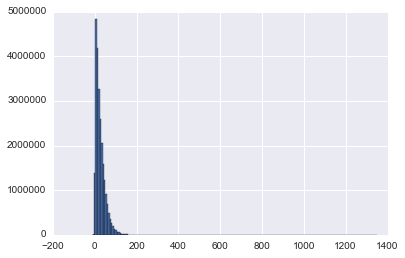

In [18]:
df.value.hist(bins=200)

TODO
 - Stacked Line Chart für Messstationen von Kreisen (Kreis)
 - Autobahnen, Schiffe, Heimöfen?

## Stationen mit mehr als 40 µg/m^3 in 2015

In [19]:
df_2015 = df[df.index.year == 2015]
mean_2015 = df_2015.groupby('Station').value.mean()
exceeding_40 = mean_2015[mean_2015 > 40].reset_index()
stations_exceeding_40 = exceeding_40.merge(stations, on='Station')
stations_exceeding_40.sort_index(by='value', ascending=False)

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


Station      value                          Stationsname        Kategorie  \
13  DEBW118  86.545635            Stuttgart Am Neckartor (S)  Luftmessstation   
24  DEBY115  83.602770              München/Landshuter Allee  Luftmessstation   
11  DEBW116  76.781338      Stuttgart Hohenheimer Straße (S)  Luftmessstation   
18  DEBW147  69.578528        Reutlingen Lederstraße Ost (S)  Luftmessstation   
56  DENW211  66.280449                Köln Clevischer Ring 3  Luftmessstation   
65  DESH052  64.132713               Kiel-Theodor-Heuss-Ring  Luftmessstation   
19  DEBW152  63.607577  Heilbronn Weinsberger Straße Ost (S)  Luftmessstation   
21  DEBY037  63.550944                       München/Stachus  Luftmessstation   
41  DEHH068  62.880004                 Hamburg Habichtstraße  Luftmessstation   
42  DEHH070  61.886373  Hamburg Max-Brauer-Allee II (Straße)  Luftmessstation   
10  DEBW099  61.377524          Stuttgart_Arnulf-Klett-Platz  Luftmessstation   
31  DEHE040  60.536895                 Darmstadt-Hügelstraße  Luftmessstation   
47  DENW082  58.911818            Düsseldorf Corneliusstraße  Luftmessstation   
12  DEBW117  57.845249       Ludwigsburg Friedrichstraße (S)  Luftmessstation   
59  DERP010  56.603178                    Mainz-Parcusstraße  Luftmessstation   
15  DEBW122  55.706564        Freiburg Schwarzwaldstraße (V)  Luftmessstation   
37  DEHE112  53.480666          Wiesbaden-Schiersteiner Str.  Luftmessstation   
6   DEBE067  52.973237                     B Hardenbergplatz  Luftmessstation   
30  DEHE037  52.796392                  Wiesbaden-Ringkirche  Luftmessstation   
32  DEHE041  52.751185               Frankfurt-Friedb.Ldstr.  Luftmessstation   
51  DENW188  52.580817       Oberhausen Mülheimer Straße 117  Luftmessstation   
46  DENI143  52.329650           Oldenburg Heiligengeistwall  Luftmessstation   
3   DEBE063  51.618675            B Neukölln-Silbersteinstr.  Luftmessstation   
4   DEBE064  51.526252          B Neukölln-Karl-Marx-Str. 76  Luftmessstation   
52  DENW189  51.477756                       Wuppertal Gathe  Luftmessstation   
54  DENW207  50.177560                  Aachen Wilhelmstraße  Luftmessstation   
44  DENI067  50.159570                     Osnabrück-Verkehr  Luftmessstation   
55  DENW208  49.887546  Gelsenkirchen Kurt-Schumacher-Straße  Luftmessstation   
17  DEBW136  49.710199               Tübingen Mühlstraße (S)  Luftmessstation   
39  DEHH026  49.376539              Hamburg Stresemannstraße  Luftmessstation   
68  DESN084  49.230857                      Dresden-Bergstr.  Luftmessstation   
50  DENW136  49.182419             Dortmund Brackeler Straße  Luftmessstation   
43  DENI048  49.131685                      Hannover Verkehr  Luftmessstation   
23  DEBY110  49.015706                   Augsburg/Karlstraße  Luftmessstation   
7   DEBE069  48.914547       B Mariendorf, Mariendorfer Damm  Luftmessstation   
69  DEST102  48.605196                  Halle/Paracelsusstr.  Luftmessstation   
48  DENW133  48.522062             Hagen Graf-von-Galen-Ring  Luftmessstation   
40  DEHH064  48.174256                 Hamburg Kieler Straße  Luftmessstation   
26  DEBY120  48.064358          Nürnberg/Von-der-Tann-Straße  Luftmessstation   
2   DEBE061  47.577187             B Steglitz-Schildhornstr.  Luftmessstation   
14  DEBW120  47.196880             Leonberg Grabenstraße (S)  Luftmessstation   
36  DEHE062  47.151997                Marburg-Univers.Straße  Luftmessstation   
28  DEHB006  47.141014                      Bremen Verkehr 1  Luftmessstation   
58  DENW355  47.006058      Leverkusen Gustav-Heinemann-Str.  Luftmessstation   
9   DEBW098  46.970439               Mannheim_Friedrichsring  Luftmessstation   
61  DERP041  46.348905             Ludwigshafen-Heinigstraße  Luftmessstation   
57  DENW212  46.343359                   Köln Turiner Straße  Luftmessstation   
35  DEHE061  44.938184                     Gießen-Westanlage  Luftmessstation   
62  DERP045  44.834192            K

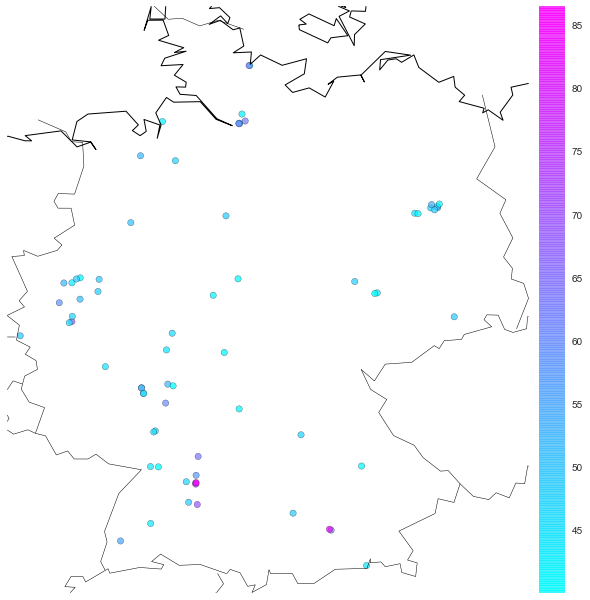

In [20]:
plot_map(stations_exceeding_40, 'value')

Kann man denn vom Mittelwert 2015 schon auf den Gesamtjahresmittelwert schließen? Nein, natürlich nicht. Aber die Tendenz ist, dass die Stickoxide im Winter steigen. Hier die Monatsmittelwerte aller Jahre im Datensatz.

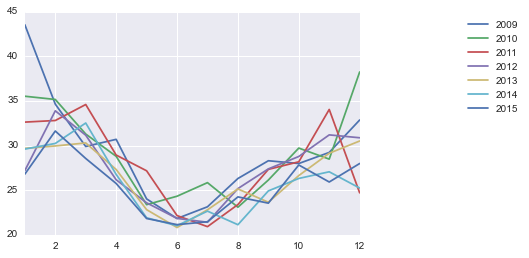

In [21]:
for year, grouped in df.groupby(df.index.year):
    grouped.groupby(grouped.index.month).value.mean().plot(label=year)
plt.legend(bbox_to_anchor=(1.5,1))

## Stationen 2015 mit Anzahl Überschreitungen von Stundenwerten 200 µg/m^3 im Jahr 2015

In [22]:
greater_200 = df[df.value > 200]
exceeding_200_count = (greater_200.groupby([greater_200.index.year, greater_200.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2015 = exceeding_200_count[(exceeding_200_count.jahr == 2015)]

exceeding_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_stations_2015.sort_index(by='anzahl', ascending=False)

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


jahr  Station  anzahl                          Stationsname  \
13  2015  DEHE040      57                 Darmstadt-Hügelstraße   
7   2015  DEBW118      51            Stuttgart Am Neckartor (S)   
11  2015  DEBY115      31              München/Landshuter Allee   
28  2015  DESH052      16               Kiel-Theodor-Heuss-Ring   
5   2015  DEBW116      15      Stuttgart Hohenheimer Straße (S)   
14  2015  DEHE041      12               Frankfurt-Friedb.Ldstr.   
24  2015  DERP010      10                    Mainz-Parcusstraße   
25  2015  DERP011       9                      Mainz-Rheinallee   
16  2015  DEHH068       7                 Hamburg Habichtstraße   
31  2015  DESN084       5                      Dresden-Bergstr.   
10  2015  DEBY030       3   Saal a.d. Donau/Regensburger Straße   
17  2015  DEHH070       3  Hamburg Max-Brauer-Allee II (Straße)   
26  2015  DERP012       3                 Mainz-Große Langgasse   
8   2015  DEBW147       3        Reutlingen Lederstraße Ost (S)   
6   2015  DEBW117       3       Ludwigsburg Friedrichstraße (S)   
4   2015  DEBW098       3               Mannheim_Friedrichsring   
9   2015  DEBW152       3  Heilbronn Weinsberger Straße Ost (S)   
21  2015  DENW207       2                  Aachen Wilhelmstraße   
12  2015  DEHE037       2                  Wiesbaden-Ringkirche   
18  2015  DENI048       1                      Hannover Verkehr   
19  2015  DENI157       1            Wolfsburg Heßlinger Straße   
20  2015  DENW134       1               Essen Gladbecker Straße   
1   2015  DEBE063       1            B Neukölln-Silbersteinstr.   
22  2015  DENW211       1                Köln Clevischer Ring 3   
23  2015  DENW356       1               Lüdenscheid Lennestraße   
15  2015  DEHE112       1          Wiesbaden-Schiersteiner Str.   
3   2015  DEBW080       1      Karlsruhe_Reinhold-Frank-Strasse   
27  2015  DERP041       1             Ludwigshafen-Heinigstraße   
2   2015  DEBE067       1                     B Hardenbergplatz   
29  2015  DESL018       1                              Sulzbach   
30  2015  DESN025       1                         Leipzig-Mitte   
0   2015  DEBE061       1             B Steglitz-Schildhornstr.   

          Kategorie Synonym Aktiv seit  Aktivitätsperiode: von   \
13  Luftmessstation     NaN  1993-11-01              1993-11-01   
7   Luftmessstation     NaN  2003-12-23              2003-12-23   
11  Luftmessstation     NaN  2004-07-01              2004-07-01   
28  Luftmessstation     NaN  2012-01-01              2012-01-01   
5   Luftmessstation     NaN  2003-12-23              2003-12-23   
14  Luftmessstation     NaN  1993-03-01              1993-03-01   
24  Luftmessstation     NaN  1979-01-01              1979-01-01   
25  Luftmessstation     NaN  1987-02-19              1987-02-19   
16  Luftmessstation    68HB  2002-01-01              2002-01-01   
31  Luftmessstation     NaN  2005-01-01              2005-01-01   
10  Luftmessstation     NaN  1978-08-01              1978-08-01   
17  Luftmessstation    70MB  2002-03-01              2002-03-01   
26  Luftmessstation     NaN  1992-01-01              1992-01-01   
8   Luftmessstation     NaN  2007-03-21              2007-03-21   
6   Luftmessstation     NaN  2003-12-23              2003-12-23   
4   Luftmessstation     NaN  1994-04-28              1994-04-28   
9   Luftmessstation     NaN  2009-01-01              2009-01-01   
21  Luftmessstation    VACW  2007-01-10              2007-01-10   
12  Luftmessstation     NaN  1991-08-01              1991-08-01   
18  Luftmessstation     NaN  1989-07-01              1989-07-01   
19  Luftmessstation     NaN  2013-01-01              2013-01-01   
20  Luftmessstation    VEAE  2003-10-29              2003-10-29   
1   Luftmessstation     NaN  1996-05-01              1996-05-01   
22  Luftmessstation     NaN  2006-05-06              2006-05-06   
23  Luftmessstation    VLSL  2015-01-08              2015-01-08   
15  Luftmessstation     NaN  2012-01-01           

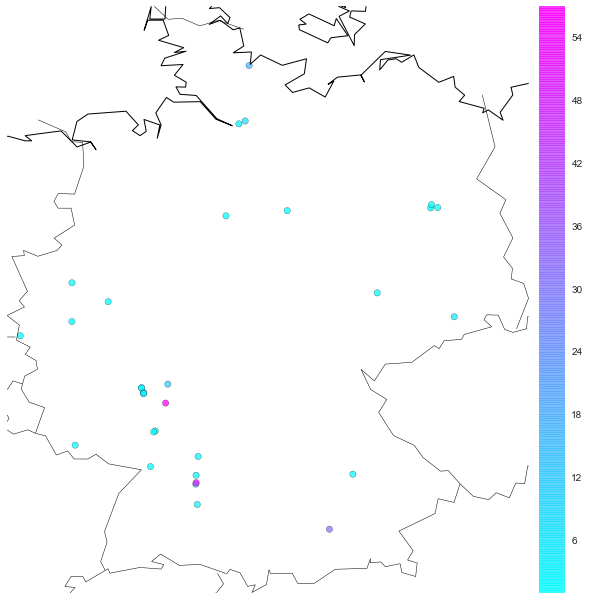

In [23]:
plot_map(exceeding_stations_2015, 'anzahl')

## Stationen 2015 mit Anzahl Überschreitungen von Stundenwerten 100 µg/m^3 bis zum 30.9.

In [24]:
greater_100 = df[df.value > 100]
exceeding_100_count = (greater_100.groupby([greater_100.index.year, greater_100.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_100_in_2015 = exceeding_100_count[(exceeding_100_count.jahr == 2015)]

exceeding_100_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_100_stations_2015.sort_index(by='anzahl', ascending=False)

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


jahr  Station  anzahl                          Stationsname  \
13  2015  DEHE040      57                 Darmstadt-Hügelstraße   
7   2015  DEBW118      51            Stuttgart Am Neckartor (S)   
11  2015  DEBY115      31              München/Landshuter Allee   
28  2015  DESH052      16               Kiel-Theodor-Heuss-Ring   
5   2015  DEBW116      15      Stuttgart Hohenheimer Straße (S)   
14  2015  DEHE041      12               Frankfurt-Friedb.Ldstr.   
24  2015  DERP010      10                    Mainz-Parcusstraße   
25  2015  DERP011       9                      Mainz-Rheinallee   
16  2015  DEHH068       7                 Hamburg Habichtstraße   
31  2015  DESN084       5                      Dresden-Bergstr.   
10  2015  DEBY030       3   Saal a.d. Donau/Regensburger Straße   
17  2015  DEHH070       3  Hamburg Max-Brauer-Allee II (Straße)   
26  2015  DERP012       3                 Mainz-Große Langgasse   
8   2015  DEBW147       3        Reutlingen Lederstraße Ost (S)   
6   2015  DEBW117       3       Ludwigsburg Friedrichstraße (S)   
4   2015  DEBW098       3               Mannheim_Friedrichsring   
9   2015  DEBW152       3  Heilbronn Weinsberger Straße Ost (S)   
21  2015  DENW207       2                  Aachen Wilhelmstraße   
12  2015  DEHE037       2                  Wiesbaden-Ringkirche   
18  2015  DENI048       1                      Hannover Verkehr   
19  2015  DENI157       1            Wolfsburg Heßlinger Straße   
20  2015  DENW134       1               Essen Gladbecker Straße   
1   2015  DEBE063       1            B Neukölln-Silbersteinstr.   
22  2015  DENW211       1                Köln Clevischer Ring 3   
23  2015  DENW356       1               Lüdenscheid Lennestraße   
15  2015  DEHE112       1          Wiesbaden-Schiersteiner Str.   
3   2015  DEBW080       1      Karlsruhe_Reinhold-Frank-Strasse   
27  2015  DERP041       1             Ludwigshafen-Heinigstraße   
2   2015  DEBE067       1                     B Hardenbergplatz   
29  2015  DESL018       1                              Sulzbach   
30  2015  DESN025       1                         Leipzig-Mitte   
0   2015  DEBE061       1             B Steglitz-Schildhornstr.   

          Kategorie Synonym Aktiv seit  Aktivitätsperiode: von   \
13  Luftmessstation     NaN  1993-11-01              1993-11-01   
7   Luftmessstation     NaN  2003-12-23              2003-12-23   
11  Luftmessstation     NaN  2004-07-01              2004-07-01   
28  Luftmessstation     NaN  2012-01-01              2012-01-01   
5   Luftmessstation     NaN  2003-12-23              2003-12-23   
14  Luftmessstation     NaN  1993-03-01              1993-03-01   
24  Luftmessstation     NaN  1979-01-01              1979-01-01   
25  Luftmessstation     NaN  1987-02-19              1987-02-19   
16  Luftmessstation    68HB  2002-01-01              2002-01-01   
31  Luftmessstation     NaN  2005-01-01              2005-01-01   
10  Luftmessstation     NaN  1978-08-01              1978-08-01   
17  Luftmessstation    70MB  2002-03-01              2002-03-01   
26  Luftmessstation     NaN  1992-01-01              1992-01-01   
8   Luftmessstation     NaN  2007-03-21              2007-03-21   
6   Luftmessstation     NaN  2003-12-23              2003-12-23   
4   Luftmessstation     NaN  1994-04-28              1994-04-28   
9   Luftmessstation     NaN  2009-01-01              2009-01-01   
21  Luftmessstation    VACW  2007-01-10              2007-01-10   
12  Luftmessstation     NaN  1991-08-01              1991-08-01   
18  Luftmessstation     NaN  1989-07-01              1989-07-01   
19  Luftmessstation     NaN  2013-01-01              2013-01-01   
20  Luftmessstation    VEAE  2003-10-29              2003-10-29   
1   Luftmessstation     NaN  1996-05-01              1996-05-01   
22  Luftmessstation     NaN  2006-05-06              2006-05-06   
23  Luftmessstation    VLSL  2015-01-08              2015-01-08   
15  Luftmessstation     NaN  2012-01-01           

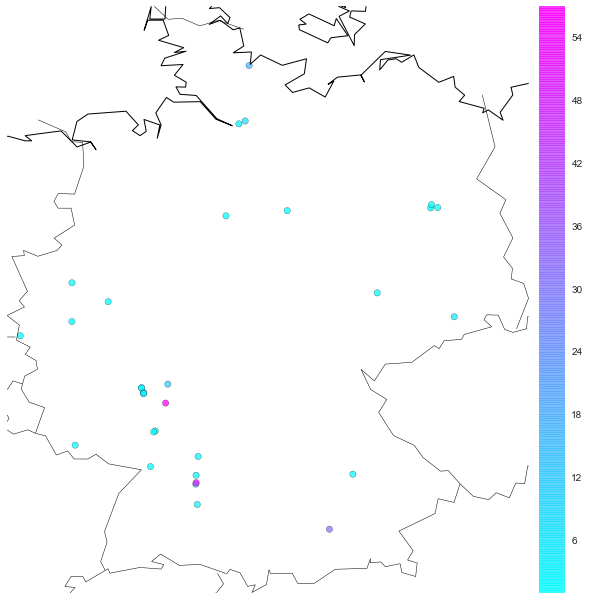

In [25]:
plot_map(exceeding_100_stations_2015, 'anzahl')

In [26]:
stuttgart_bbox = {
  'lon': 9.182778,
  'lat': 48.775556,
  'll_lon': 8.74641,
  'll_lat': 48.4975,
  'ur_lon': 10.4956,
  'ur_lat': 49.7913
}

def plot_stations(stations):
    mean_lat = stations.lat.mean()
    mean_lng = stations.lng.mean()
    fmap = folium.Map(location=[mean_lat, mean_lng], zoom_start=11, height=800)
    for i, station in stations.iterrows():
        fmap.circle_marker(location=[station.lat, station.lng], radius=50,
                    popup=u'{}: {}'.format(station.Stationsname, station.value), line_color='#f00',
                    fill_color='#f00')
    fmap.create_map(path='stuttgart.html')
    return fmap


filtered = df[df.index.year == 2015]
filtered = filtered.groupby('Station')
filtered = filtered.value.median().reset_index()
filtered = filtered.merge(stations, on='Station')

plot_stations(filtered)

In [27]:
stations[stations.ags == '81110']

Station                      Stationsname        Kategorie Synonym  \
179  DEBW011            Stuttgart-Zuffenhausen  Luftmessstation     NaN   
180  DEBW012                   Stuttgart-Mitte  Luftmessstation     NaN   
181  DEBW013           Stuttgart Bad Cannstatt  Luftmessstation     NaN   
182  DEBW014                   Stuttgart-Hafen  Luftmessstation     NaN   
257  DEBW099      Stuttgart_Arnulf-Klett-Platz  Luftmessstation     NaN   
258  DEBW100        Stuttgart-Vaihingen-Straße  Luftmessstation     NaN   
274  DEBW116  Stuttgart Hohenheimer Straße (S)  Luftmessstation     NaN   
276  DEBW118        Stuttgart Am Neckartor (S)  Luftmessstation     NaN   
277  DEBW119       Stuttgart Siemensstraße (S)  Luftmessstation     NaN   
292  DEBW134       Stuttgart Waiblinger Straße  Luftmessstation     NaN   

    Aktiv seit  Aktivitätsperiode: von  Aktivitätsperiode: bis Verlegt  \
179  1981-01-01              1981-01-01             2010-12-31    nein   
180  1981-01-01              1981-01-01             2000-06-30    nein   
181  1981-01-01              1981-01-01                    NaT    nein   
182  1981-01-01              1981-01-01             2003-09-30    nein   
257  1994-12-06              1994-12-06                    NaT    nein   
258  1994-01-01              1994-01-01             1999-02-23    nein   
274  2003-12-23              2003-12-23                    NaT     NaN   
276  2003-12-23              2003-12-23                    NaT     NaN   
277  2003-12-23              2003-12-23             2007-12-31     NaN   
292  2004-01-01              2004-01-01                    NaT     NaN   

                         Straße   Nr    PLZ        Ort Länge dezimal  \
179  Ludwigsburger-/Frankenstr.  NaN  70435  Stuttgart      9,172506   
180          Hegel-/Lerchenstr.  NaN  70176  Stuttgart      9,164834   
181     Gnesenerstr./Seuberstr.  NaN  70374  Stuttgart      9,229745   
182                Am Mittelkai  NaN  70329  Stuttgart      9,265529   
257          Arnulf-Klett-Platz  NaN  70173  Stuttgart      9,180720   
258        Möhringer Landstraße  NaN  70563  Stuttgart      9,113306   
274          Hohenheimer Straße   64  70184  Stuttgart      9,184490   
276                Am Neckartor  NaN  70190  Stuttgart      9,191010   
277               Siemensstraße   43  70469  Stuttgart      9,175299   
292           Waiblinger Straße   22  70374  Stuttgart      9,220360   

    Breite dezimal  Höhe Stationsumgebung (EoI) Art der Station (EoI)  \
179      48,825575   272     städtisches Gebiet               Verkehr   
180      48,775865   260     städtisches Gebiet           Hintergrund   
181      48,808800   235     städtisches Gebiet           Hintergrund   
182      48,752251   235  vorstädtisches Gebiet             Industrie   
257      48,783130   244     städtisches Gebiet               Verkehr   
258      48,730066   410     städtisches Gebiet               Verkehr   
274      48,768710   302     städtisches Gebiet               Verkehr   
276      48,788100   239     städtisches Gebiet               Verkehr   
277      48,811099   296     städtisches Gebiet               Verkehr   
292      48,803770   223     städtisches Gebiet               Verkehr   

     Einwohnerzahl (EoI) Abstand zur Straße (EoI) Bemerkung (EoI)  \
179                  NaN                 >10-50 m             NaN   
180                  NaN                  >1-10 m             NaN   
181                  NaN                 >10-50 m             NaN   
182                  NaN                >50-100 m             NaN   
257                  NaN                  >1-10 m             NaN   
258                  NaN                  >1-10 m             NaN   
274                  NaN                  >1-10 m             NaN   
276                  NaN                  >1-10 m             NaN   
277                  NaN                      NaN             NaN   
292                  NaN                  >1-10 m             NaN   

    Lok

## Tendenzen der Stationen über die Jahre

Generell geht es runter, im Schnitt -3µg/m^3 zwischen 2009 und 2014. Aber es gibt ~45 Messstationen, die 2014 schlechtere Jahresmittelwerte als 2009 haben.

In [28]:
df_2009 = df[df.index.year == 2009]
df_2014 = df[df.index.year == 2014]
stations_mean_2009 = df_2009.groupby('Station').value.mean()
stations_mean_2014 = df_2014.groupby('Station').value.mean()
stations_difference = stations_mean_2014 - stations_mean_2009
stations_difference.describe()

count    361.000000
mean      -3.828525
std        4.453329
min      -32.223841
25%       -5.316911
50%       -2.937584
75%       -1.043384
max        5.075042
Name: value, dtype: float64

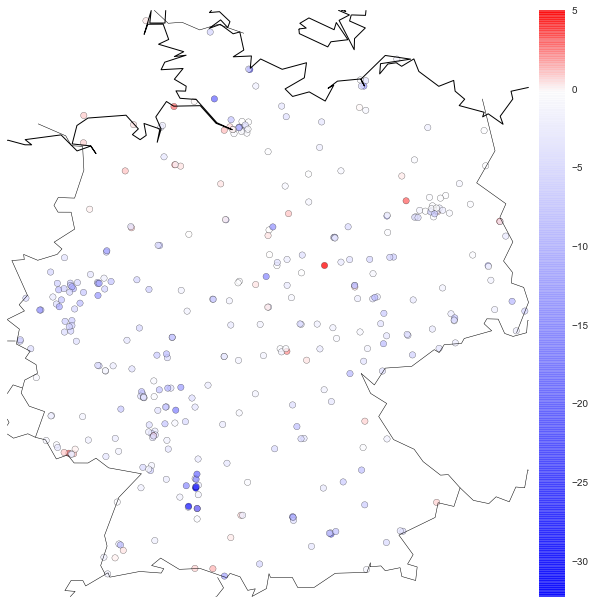

In [29]:
station_diff = stations_difference.reset_index().merge(stations, on="Station")
plot_map(station_diff, 'value', cmap='bwr', diverging=True)

In [30]:
station_diff.sort_index(by='value', ascending=False).head(50)

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


Station     value                   Stationsname  \
450  DEST095  5.075042                   Aschersleben   
20   DEBB067  2.931137                          Nauen   
5    DEBB042  2.849716    Frankfurt (Oder), 1997-2014   
393  DESL010  2.793254            Saarbrücken-Burbach   
265  DENI059  2.602516                     Elbmündung   
166  DEHB001  2.197203                   Bremen-Mitte   
469  DETH040  2.087119               Großer Eisenberg   
345  DERP002  2.062715             Ludwigshafen-Mitte   
70   DEBW038  1.428813                Friedrichshafen   
268  DENI063  1.261382                     Altes Land   
394  DESL011  1.102706           Saarbrücken-Eschberg   
262  DENI053  1.069643                   Südoldenburg   
251  DENI020  1.030536                      Wolfsburg   
255  DENI038  0.983518                      Osnabrück   
397  DESL017  0.968296    Völklingen-City Stadionstr.   
264  DENI058  0.965266               Ostfries. Inseln   
75   DEBW052  0.813483                       Konstanz   
253  DENI029  0.802911                   Ostfriesland   
156  DEBY118  0.732489        Passau/Stelzhamerstraße   
140  DEBY075  0.708775  Weiden i.d.OPf./Nikolaistraße   
63   DEBW027  0.670694                     Reutlingen   
41   DEBE063  0.618977     B Neukölln-Silbersteinstr.   
220  DEHH049  0.602134   Hamburg Blankenese-Baursberg   
58   DEBW019  0.584522                            Ulm   
252  DENI028  0.549467                      Eichsfeld   
261  DENI052  0.536839                       Allertal   
466  DETH027  0.480518                        Neuhaus   
271  DENI070  0.470602              Salzgitter-Drütte   
167  DEHB002  0.448319                     Bremen-Ost   
486  DEUB004  0.436817                   Schauinsland   
254  DENI031  0.436396                      Jadebusen   
441  DEST075  0.418364      Halle/Merseburger Strasse   
485  DEUB001  0.409124                     Westerland   
484  DETH095  0.323865          Mühlhausen Bastmarkt    
74   DEBW046  0.281830                       Biberach   
8    DEBB048  0.273578                      Neuruppin   
398  DESL018  0.262862                       Sulzbach   
66   DEBW031  0.195525                Schwarzwald-Süd   
258  DENI043  0.162548                        Emsland   
227  DEHH073  0.160087    Hamburg Finkenwerder Airbus   
263  DENI054  0.150224                       Hannover   
233  DEMV004  0.046685                         Gülzow   
389  DESH035  0.041425  Brunsbüttel-Cuxhavener Straße   
256  DENI041 -0.070618                  Weserbergland   
248  DENI011 -0.089850                   Braunschweig   
249  DENI016 -0.153475              Oker/Harlingerode   
266  DENI060 -0.171133                       Wendland   
270  DENI068 -0.177960              Göttingen-Verkehr   
46   DEBE068 -0.183218         B Mitte, Brückenstraße   
451  DEST098 -0.184122    Unterharz / Friedrichsbrunn   

                            Kategorie         Synonym Aktiv seit   \
450                   Luftmessstation             NaN  2000-11-02   
20   Luft- und Depositionsmessstation             NaN  2003-08-11   
5                     Luftmessstation            FFMA  1997-04-21   
393                   Luftmessstation            BURB  1983-07-01   
265                   Luftmessstation             NaN  1998-03-20   
166                   Luftmessstation             NaN  1987-01-01   
469                   Luftmessstation             NaN  1994-12-04   
345                   Luftmessstation             NaN  1978-01-01   
70                    Luftmessstation             NaN  1987-01-01   
268                   Luftmessstation             NaN  1999-02-11   
394                   Luftmessstation            OSSB  1983-07-01   
262                   Luftmessstation             NaN  1991-04-03   
251                   Luftmessstation             NaN  1988-02-01   
255                   Luftmessstation             NaN  1988-10-01   
397                   Luftmessstation            VKCY  1989-05

In [31]:
kreise = pd.read_csv('data/12411-0014.csv', skiprows=5, skipfooter=5, delimiter=';', encoding='latin-1')
kreise.rename(columns={'Unnamed: 0': 'ags', 'Unnamed: 1': 'Kreisname'}, inplace=True)
kreise['ags'] = kreise['ags'].apply(lambda x: '{:0>5d}'.format(x))
kreise = kreise[['ags', 'Kreisname']]
kreise.head()


/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


ags                     Kreisname
0  01001   Flensburg, kreisfreie Stadt
1  01002        Kiel, kreisfreie Stadt
2  01003      Lübeck, kreisfreie Stadt
3  01004  Neumünster, kreisfreie Stadt
4  01051       Dithmarschen, Landkreis

In [32]:
df_2009_ags = df_2009.merge(stations[['Station', 'ags']], on='Station').groupby('ags').value.mean()
df_2014_ags = df_2014.merge(stations[['Station', 'ags']], on='Station').groupby('ags').value.mean()

df_diff_ags = df_2014_ags - df_2009_ags
df_diff_ags = df_diff_ags.order(ascending=False)
df_diff_ags.describe()

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


count    224.000000
mean      -3.138674
std        4.649941
min      -21.422409
25%       -5.289598
50%       -2.598710
75%       -0.695285
max       18.016377
Name: value, dtype: float64

## Kreise, in denen es von 2009 - 2014 schlechter wurde

In [33]:
df_diff_ags_cleaned = df_diff_ags.reset_index()
df_diff_ags_cleaned.ags = (pd.to_numeric(df_diff_ags_cleaned.ags)
                                                  .apply(lambda x: int(x / 10.0))
                                                  .apply(lambda x: '{:05d}'.format(x)))
df_diff_ags_cleaned = df_diff_ags_cleaned.merge(kreise, on='ags')
df_diff_ags_cleaned = df_diff_ags_cleaned.sort_values(by='value', ascending=False)
df_diff_ags_cleaned.head(20)

ags      value                                     Kreisname
0   03403  18.016377       Oldenburg (Oldenburg), kreisfreie Stadt
1   08121  15.077052                   Heilbronn, kreisfreie Stadt
2   03103  10.735965                   Wolfsburg, kreisfreie Stadt
3   08215   7.616578                          Karlsruhe, Landkreis
4   05513   7.499909               Gelsenkirchen, kreisfreie Stadt
5   09663   6.660836                    Würzburg, kreisfreie Stadt
6   07316   5.178678  Neustadt an der Weinstraße, kreisfreie Stadt
7   08226   2.629007                            Rhein-Neckar-Kreis
8   03352   2.602516                           Cuxhaven, Landkreis
9   01061   2.489519                          Steinburg, Landkreis
10  09273   2.437348                            Kelheim, Landkreis
11  08435   1.428813                                 Bodenseekreis
12  08317   1.378241                                  Ortenaukreis
13  03359   1.261382                              Stade, Landkreis
14  08222   1.079239                    Mannheim, kreisfreie Stadt
15  03453   1.069643                        Cloppenburg, Landkreis
16  03452   0.965266                             Aurich, Landkreis
17  03155   0.815490                           Northeim, Landkreis
18  08335   0.813483                           Konstanz, Landkreis
19  03402   0.802911                       Emden, kreisfreie Stadt

In [34]:
df_diff_ags_cleaned.describe()

value
count  157.000000
mean    -3.366817
std      5.301529
min    -21.422409
25%     -5.878348
50%     -2.991157
75%     -0.358820
max     18.016377

In [35]:
import folium

def make_kreise_map(geo_data, key='value', diverging=False, fill='PRGn'):

    # We use the geo json file for our metro we generated above
    # geo_path = r'kreise.geojson'
    geo_path = 'geodata/kreise.topo.json'
    
    geo_data = geo_data.copy()
    geo_data[key] *= -1

    min_val = geo_data[key].min()
    q1 = geo_data[key].quantile( .25)
    q2 = geo_data[key].quantile( .5)
    q3 = geo_data[key].quantile( .75)
    q4 = geo_data[key].quantile( .9)
    max_val = geo_data[key].max()
    scale = None
    if diverging:
        scale = [min_val, min_val / 2, 0, 1, max_val / 2, max_val]
        print(scale)
    else:
        scale = [min_val, q1, q2, q3, q4, max_val]

    m = folium.Map(location=[52, 10], zoom_start=6, height=800)
    m.geo_json(geo_path=geo_path, data=geo_data, data_out='%s_diff.json' % key,
                 columns=['ags', key],
                 threshold_scale=scale,
                 key_on='feature.properties.AGS',
                 fill_color=fill, fill_opacity=0.7, line_opacity=0.3,
                 legend_name='',
                 topojson='objects.kreise', reset=True
    )
    m.create_map(path='map_diff_pp.html')
    return m

### Tendenzen der Kreise

Grün: 2014 mehr als 2009, rosa: weniger, schwarz: unbekannt

In [36]:
make_kreise_map(df_diff_ags_cleaned, diverging=True)

[-18.016377378260103, -9.0081886891300513, 0, 1, 10.711204252485729, 21.422408504971457]


### Durchschnittswerte der Kreise 2015

In [37]:
df_2015_ags = df_2015.merge(stations[['ags', 'Station']], on='Station').groupby('ags').value.mean().reset_index()
df_2015_ags.ags = (pd.to_numeric(df_2015_ags.ags).apply(lambda x: int(x / 10.0))
                                                 .apply(lambda x: '{:05d}'.format(x)))
df_2015_ags = df_2015_ags.merge(kreise, on='ags')
df_2015_ags.sort_index(by='value', ascending=True).head(50)

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


ags      value                                       Kreisname
121  08315   4.221457             Breisgau-Hochschwarzwald, Landkreis
6    01054   5.427415                        Nordfriesland, Landkreis
164  09780   5.592239                           Oberallgäu, Landkreis
89   07134   6.003801                           Birkenfeld, Landkreis
144  09372   6.139993                                 Cham, Landkreis
103  07340   6.340457                         Südwestpfalz, Landkreis
93   07232   6.502067                         Eifelkreis Bitburg-Prüm
64   05970   6.726692                  Siegen-Wittgenstein, Landkreis
85   06636   6.781093                             Werra-Meißner-Kreis
25   03360   7.139538                               Uelzen, Landkreis
137  09188   7.441339                            Starnberg, Landkreis
73   06434   7.709294                                 Hochtaunuskreis
87   07132   8.049787            Altenkirchen (Westerwald), Landkreis
102  07336   8.066570                                Kusel, Landkreis
15   03153   8.213774                               Goslar, Landkreis
84   06635   8.282827                  Waldeck-Frankenberg, Landkreis
30   03452   8.953456                               Aurich, Landkreis
16   03155   8.983560                             Northeim, Landkreis
83   06633   9.257687                               Kassel, Landkreis
7    01057   9.421889                                 Plön, Landkreis
91   07143   9.596083                                 Westerwaldkreis
29   03405  11.146214                 Wilhelmshaven, kreisfreie Stadt
21   03354  11.269309                    Lüchow-Dannenberg, Landkreis
120  08315  11.359764             Breisgau-Hochschwarzwald, Landkreis
20   03352  11.895038                             Cuxhaven, Landkreis
82   06632  12.075191                   Hersfeld-Rotenburg, Landkreis
65   05974  12.164412                                Soest, Landkreis
154  09575  12.316396  Neustadt an der Aisch-Bad Windsheim, Landkreis
23   03358  13.073939                                      Heidekreis
24   03359  13.951261                                Stade, Landkreis
31   03453  14.132341                          Cloppenburg, Landkreis
110  08128  14.171866                               Main-Tauber-Kreis
19   03257  14.363421                           Schaumburg, Landkreis
124  08326  15.154706                          Schwarzwald-Baar-Kreis
32   03454  15.377850                              Emsland, Landkreis
4    01004  15.710872                    Neumünster, kreisfreie Stadt
135  09180  15.962512               Garmisch-Partenkirchen, Landkreis
74   06435  16.070602                               Main-Kinzig-Kreis
112  08211  16.197924                   Baden-Baden, kreisfreie Stadt
12   03102  16.393448                    Salzgitter, kreisfreie Stadt
148  09464  16.491599                           Hof, kreisfreie Stadt
22   03355  16.667556                             Lüneburg, Landkreis
26   03402  16.669985                         Emden, kreisfreie Stadt
158  09676  16.698412                           Miltenberg, Landkreis
109  08127  17.437470                      Schwäbisch Hall, Landkreis
75   06437  17.464962                                   Odenwaldkreis
56   05554  17.660192                               Borken, Landkreis
151  09562  17.678500                      Erlangen, kreisfreie Stadt
99   07317  17.791076                     Pirmasens, kreisfreie Stadt
163  09779  17.830133                           Donau-Ries, Landkreis

In [38]:
make_kreise_map(df_2015_ags, fill='OrRd')

## Schlechteste Durchschnittswerte 2014

In [39]:
df_2014_ags = df_2014.merge(stations[['ags', 'Station']], on='Station').groupby('ags').value.mean().reset_index()
df_2014_ags.ags = (pd.to_numeric(df_2014_ags.ags).apply(lambda x: int(x / 10.0))
                                                .apply(lambda x: '{:05d}'.format(x)))
df_2014_ags = df_2014_ags.merge(kreise, on='ags')
df_2014_ags.sort_values(by='value', ascending=False).head(50)

ags      value                                Kreisname
106  08111  64.435916              Stuttgart, kreisfreie Stadt
43   05119  54.946690             Oberhausen, kreisfreie Stadt
29   03403  53.850894  Oldenburg (Oldenburg), kreisfreie Stadt
62   05914  53.417531                  Hagen, kreisfreie Stadt
110  08121  47.629498              Heilbronn, kreisfreie Stadt
71   06414  46.146803              Wiesbaden, kreisfreie Stadt
63   05916  45.682210                  Herne, kreisfreie Stadt
109  08118  45.384638                   Ludwigsburg, Landkreis
135  09162  45.081669                München, kreisfreie Stadt
10   01060  44.565346                      Segeberg, Landkreis
37   05111  43.619858             Düsseldorf, kreisfreie Stadt
70   06413  43.416997      Offenbach am Main, kreisfreie Stadt
125  08325  42.568431                      Rottweil, Landkreis
69   06412  42.379216      Frankfurt am Main, kreisfreie Stadt
68   06411  41.541382              Darmstadt, kreisfreie Stadt
51   05315  41.488504                   Köln, kreisfreie Stadt
88   07111  41.395489                Koblenz, kreisfreie Stadt
138  09187  41.353958                     Rosenheim, Landkreis
99   07315  41.026792                  Mainz, kreisfreie Stadt
121  08311  40.772635   Freiburg im Breisgau, kreisfreie Stadt
159  09663  40.647768               Würzburg, kreisfreie Stadt
61   05913  39.742624               Dortmund, kreisfreie Stadt
56   05513  39.213365          Gelsenkirchen, kreisfreie Stadt
1    01002  39.096356                   Kiel, kreisfreie Stadt
130  08416  38.084115                      Tübingen, Landkreis
8    01056  37.880365                     Pinneberg, Landkreis
144  09362  37.758125             Regensburg, kreisfreie Stadt
45   05124  37.731520              Wuppertal, kreisfreie Stadt
6    01053  37.676162           Herzogtum Lauenburg, Landkreis
118  08222  37.497720               Mannheim, kreisfreie Stadt
154  09564  37.282830               Nürnberg, kreisfreie Stadt
11   01061  36.367773                     Steinburg, Landkreis
98   07314  35.588038  Ludwigshafen am Rhein, kreisfreie Stadt
39   05113  35.176451                  Essen, kreisfreie Stadt
96   07311  35.092222    Frankenthal (Pfalz), kreisfreie Stadt
115  08212  34.451724              Karlsruhe, kreisfreie Stadt
30   03404  34.248418              Osnabrück, kreisfreie Stadt
82   06611  34.025151                 Kassel, kreisfreie Stadt
81   06534  33.804967            Marburg-Biedenkopf, Landkreis
129  08415  33.659066                    Reutlingen, Landkreis
38   05112  33.208256               Duisburg, kreisfreie Stadt
116  08215  32.897380                     Karlsruhe, Landkreis
20   03241  32.878107               Region Hannover, Landkreis
0    01001  32.862386              Flensburg, kreisfreie Stadt
55   05512  32.602424                Bottrop, kreisfreie Stadt
36   04012  32.496710            Bremerhaven, kreisfreie Stadt
152  09561  31.834157                Ansbach, kreisfreie Stadt
73   06432  31.627859             Darmstadt-Dieburg, Landkreis
40   05114  31.394339                Krefeld, kreisfreie Stadt
79   06532  31.147631                          Lahn-Dill-Kreis

# Explorations

In [40]:
stations[stations.Stationsname.str.contains(u'Heidelberg')]

Station                      Stationsname               Kategorie  \
177  DEBW009                        Heidelberg         Luftmessstation   
259  DEBW101             Heidelberg Schwimmbad         Luftmessstation   
282  DEBW124  Heidelberg Karlsruher Straße (S)         Luftmessstation   
309  DEBW151  Heidelberg Mittermaierstraße (S)         Luftmessstation   
319  DEBW161                  Forst_Heidelberg        Umweltmonitoring   
363  DEBW205             Forst_HeidelbergBuche  Depositionsmessstation   

          Synonym Aktiv seit  Aktivitätsperiode: von  Aktivitätsperiode: bis  \
177           NaN  1984-01-01              1984-01-01                    NaT   
259           NaN  1994-07-01              1994-07-01             2009-06-10   
282           NaN  2004-01-01              2004-01-01             2009-12-31   
309           NaN  2009-01-01              2009-01-01                    NaT   
319  Level II 802  2005-01-01              2005-01-01                    NaT   
363  Level II 852  2008-12-29              2008-12-29                    NaT   

    Verlegt                         Straße   Nr    PLZ         Ort  \
177    nein  Ecke Berliner-/Blumenthalstr.  NaN  69120  Heidelberg   
259    nein             Tiergarten-Freibad  NaN  69121  Heidelberg   
282     NaN              Karlsruher Straße  NaN  69126  Heidelberg   
309     NaN              Mittermaierstraße  NaN  69115  Heidelberg   
319     NaN                            NaN  NaN      0  Heidelberg   
363     NaN                            NaN  NaN      0  Heidelberg   

    Länge dezimal Breite dezimal  Höhe Stationsumgebung (EoI)  \
177      8,676700      49,419528   112     städtisches Gebiet   
259      8,658185      49,421366   110  vorstädtisches Gebiet   
282      8,687180      49,379368   113     städtisches Gebiet   
309      8,677000      49,407250   117     städtisches Gebiet   
319      8,754500      49,464300   NaN      ländliches Gebiet   
363      8,744400      49,467500   390      ländliches Gebiet   

    Art der Station (EoI)  Einwohnerzahl (EoI) Abstand zur Straße (EoI)  \
177           Hintergrund                  NaN                  >1-10 m   
259           Hintergrund                  NaN               >100-200 m   
282               Verkehr                  NaN                      NaN   
309               Verkehr                  NaN                  >1-10 m   
319           Hintergrund                  NaN                      NaN   
363           Hintergrund                  NaN                      NaN   

    Bemerkung (EoI) Lokaler Code EMEP-Code O3-Klasse aus UBA FE  \
177             NaN           HD        No                   ST   
259    Fluss:Neckar        HD-03        No                   ST   
282             NaN          NaN       NaN                  NaN   
309             NaN          NaN       NaN                  NaN   
319        Freiland          201       NaN                  NaN   
363  Freiland, eben          852       NaN                  NaN   

    NO/NO2-Klasse aus UBA FE           Bemerkung des UBA(1)  \
177                       ST                            NaN   
259                       ST                            NaN   
282                      NaN                            NaN   
309                      NaN                            NaN   
319                      NaN  keine Station im Luftmessnetz   
363                      NaN  keine Station im Luftmessnetz   

    Bemerkung des UBA(2)                       Bemerkung des Netzbetreibers  \
177                  NaN                                                NaN   
259                  NaN  nur 4/5 bis 9/10 jährlich betrieben im Auftrag...   
282                  NaN  2004 Messungen mittels Passivsammler (NO2) und...   
309                  NaN                                                NaN   
319         Level II 802                                                NaN   
363     Level II Station                                          

In [41]:
# Some stations have no entry in the DE-Dataset
df[df.Station == 'DEBW151']

Empty DataFrame
Columns: [Station, Komponente, TYPE_OF_AREA, TYPE_OF_STATION, TYPE_OF_DATA, Lieferung, value]
Index: []

In [42]:
df_stations = df.reset_index().merge(stations[['Station', 'ags']], on='Station')
df_stations = df_stations[df_stations.ags.isin(['20000'])]

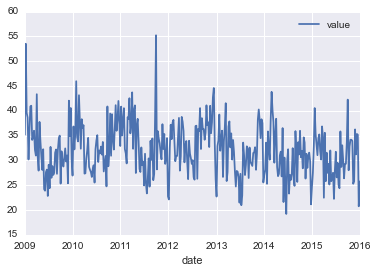

In [43]:
df_stations.set_index('date').resample('W', how='mean').plot()

## Ballungsräume

In [44]:
import json
from rtree import index

from shapely.geometry import shape, Point

class GeoIndex(object):
    def __init__(self, filename):
        with open(filename) as f:
            js = json.load(f)
        self.idx = index.Index()
        self.features = js['features']
    
        for i, feature in enumerate(self.features):
            polygon = shape(feature['geometry'])
            self.idx.insert(i, polygon.bounds)

    def covers(self, lat, lng):
        point = Point(lng, lat)
        for j in self.idx.intersection(point.coords[0]):
            polygon = shape(self.features[j]['geometry'])
            if point.within(polygon):
                yield self.features[j]['properties']
    
    def get_feature_property(self, lat, lng, prop):
        l = list(self.covers(lat, lng))
        if l:
            return l[0][prop]
        return None
    
gemeinde_index = GeoIndex('geodata/gemeinden_sim200.geojson')

In [45]:
ballungsraum = {
    'Freiburg': ['Freiburg im Breisgau', 'Umkirch'],
    'Karlsruhe': ['Karlsruhe', 'Ettlingen'],
    'Stuttgart': [u"Asperg", u"Bietigheim-Bissingen", u"Böblingen", u"Deizisau", u"Denkendorf", u"Ditzingen",
                  u"Esslingen am Neckar", u"Fellbach", u"Filderstadt", u"Freiberg am Neckar", u"Gerlingen",
                  u"Köngen", u"Korntal-Münchingen", u"Kornwestheim", u"Leinfelden-Echterdingen", u"Leonberg",
                  u"Ludwigsburg", u"Magstadt", u"Möglingen", u"Neuhausen auf den Fildern", u"Ostfildern",
                  u"Plochingen", u"Remseck am Neckar", u"Sindelfingen", u"Steinenbronn", u"Stuttgart", u"Tamm",
                  u"Wendlingen am Neckar", u"Wernau (Neckar)"],
    'Mannheim/Heidelberg': [u'Edingen-Neckarhausen', u'Eppelheim', u'Heidelberg', u'Ilvesheim', u'Ladenburg',
                            u'Mannheim', u'Plankstadt', u'Schwetzingen'],
    'Hamburg': ['Hamburg'],
    'Berlin': ['Berlin'],
}
reverse_ballungsraum = {v: k for k, vlist in ballungsraum.items() for v in vlist}

assign_geofeature = lambda idx, key: lambda x: idx.get_feature_property(x.lat, x.lng, key)

stations['gemeinde'] = stations.apply(assign_geofeature(gemeinde_index, 'GEN'), axis=1)

stations['ballungsraum'] = stations['gemeinde'].apply(lambda x: reverse_ballungsraum.get(x))

In [46]:
stations['gemeinde'].value_counts().head(10)

Hamburg              79
Berlin               67
Köln                 31
Essen                20
Frankfurt am Main    20
Duisburg             17
Düsseldorf           17
München              16
Gelsenkirchen        15
Castrop-Rauxel       12
Name: gemeinde, dtype: int64

In [47]:
stations['ballungsraum'].value_counts()

Hamburg                79
Berlin                 67
Stuttgart              27
Mannheim/Heidelberg    10
Karlsruhe               8
Freiburg                6
Name: ballungsraum, dtype: int64

## Anzahl der 200 µg/m^3 Überschreitungen in den Ballungsräumen 2015

2015 und 2014

In [48]:
exceeding_200_count = (greater_200.groupby([greater_200.index.year, greater_200.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2015 = exceeding_200_count[(exceeding_200_count.jahr == 2015)]
exceeding_100_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_100_stations_2015.groupby(['ballungsraum', 'Station']).anzahl.sum()

ballungsraum         Station
Berlin               DEBE061     1
                     DEBE063     1
                     DEBE067     1
Hamburg              DEHH068     7
                     DEHH070     3
Karlsruhe            DEBW080     1
Mannheim/Heidelberg  DEBW098     3
Stuttgart            DEBW116    15
                     DEBW117     3
                     DEBW118    51
Name: anzahl, dtype: int64

In [49]:
exceeding_200_count = (greater_200.groupby([greater_200.index.year, greater_200.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2014 = exceeding_200_count[(exceeding_200_count.jahr == 2014)]
exceeding_200_stations_2014 = exceeding_200_in_2014.merge(stations, on='Station')
exceeding_200_stations_2014.groupby(['ballungsraum', 'Station']).anzahl.sum()

ballungsraum  Station
Berlin        DEBE063     3
              DEBE064     3
              DEBE067     3
              DEBE069     2
Hamburg       DEHH026     1
              DEHH068    12
Karlsruhe     DEBW080     2
Stuttgart     DEBW116    16
              DEBW117     2
              DEBW118    36
              DEBW120     2
Name: anzahl, dtype: int64

Überschreitungen von 100 im Jahr 2014 nach Ballungsraum:

In [50]:
exceeding_100_count = (greater_100.groupby([greater_100.index.year, greater_100.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2015 = exceeding_100_count[(exceeding_100_count.jahr == 2015)]
exceeding_100_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_100_stations_2015.groupby(['ballungsraum', 'Station']).anzahl.sum()

ballungsraum         Station
Berlin               DEBE010      34
                     DEBE018      34
                     DEBE034      29
                     DEBE061     293
                     DEBE063     505
                     DEBE064     265
                     DEBE065      95
                     DEBE066       1
                     DEBE067     521
                     DEBE068      39
                     DEBE069     277
Freiburg             DEBW122     653
Hamburg              DEHH008       4
                     DEHH015      28
                     DEHH016       4
                     DEHH026     252
                     DEHH033       1
                     DEHH049       3
                     DEHH059       3
                     DEHH064     183
                     DEHH068    1373
                     DEHH070     620
                     DEHH072       1
                     DEHH074       7
                     DEHH079       7
Karlsruhe            DEBW080     176
         

In [51]:
exceeding_100_count = (greater_100.groupby([greater_100.index.year, greater_100.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_100_in_2014 = exceeding_100_count[(exceeding_100_count.jahr == 2014)]
exceeding_100_stations_2014 = exceeding_100_in_2014.merge(stations, on='Station')
exceeding_100_stations_2014.groupby(['ballungsraum', 'Station']).anzahl.sum()

ballungsraum         Station
Berlin               DEBE010      36
                     DEBE018      26
                     DEBE034      33
                     DEBE061     344
                     DEBE063     696
                     DEBE064     389
                     DEBE065     116
                     DEBE066       1
                     DEBE067     963
                     DEBE068      29
                     DEBE069     224
Freiburg             DEBW122    1278
Hamburg              DEHH008       8
                     DEHH015      29
                     DEHH026     506
                     DEHH033       2
                     DEHH059       8
                     DEHH064     210
                     DEHH068    1141
                     DEHH070     681
                     DEHH074       2
                     DEHH079       8
Karlsruhe            DEBW080     130
                     DEBW081      14
Mannheim/Heidelberg  DEBW005       7
                     DEBW009       2
         

## Schlechtester Stationsdurchschnittswert in den Ballungsräumen

2015 und 2014

In [52]:
df[df.index.year == 2015].merge(stations[['Station', 'ballungsraum']], on='Station').groupby(['Station', 'ballungsraum']).mean().unstack().max()

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


       ballungsraum       
value  Berlin                 52.973237
       Freiburg               55.706564
       Hamburg                62.880004
       Karlsruhe              44.573628
       Mannheim/Heidelberg    46.970439
       Stuttgart              86.545635
dtype: float64

In [53]:
df[df.index.year == 2014].merge(stations[['Station', 'ballungsraum']], on='Station').groupby(['Station', 'ballungsraum']).mean().unstack().max()

       ballungsraum       
value  Berlin                 62.064815
       Freiburg               62.316244
       Hamburg                61.623688
       Karlsruhe              45.840860
       Mannheim/Heidelberg    48.253304
       Stuttgart              88.604405
dtype: float64

## Verlauf der Ballungsräume von 2014 - 2015 nach Wochenwerten

Schlechtester Wochenwert in einem Ballungsraum.

In [54]:
week_max_2014_15 = df[df.index.year >= 2014].reset_index().merge(stations, on='Station').groupby(['date', 'ballungsraum']).value.max().unstack().resample('W', how=max)

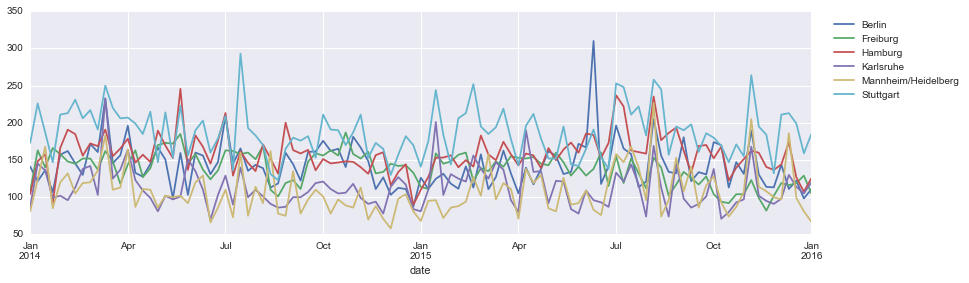

In [55]:
fig = plt.figure(figsize=(14, 4))
axes = fig.add_subplot(111)
week_max_2014_15.plot(ax=axes)
plt.legend(bbox_to_anchor=(1.2,1))

## Industriemessstellen mit den höchsten Werten

In [56]:
# Exclude fire in Krefeld (see further up) to not skew the dataset

exclude_krefeld = df[~((df.index >= datetime(2012,9,25)) & (df.index <= datetime(2012,9,29)) & (df.Station == 'DENW116'))]
worst_industry_stations = exclude_krefeld[exclude_krefeld.TYPE_OF_STATION == 'Industrie'].groupby('Station').value.max().dropna().reset_index().merge(stations, on='Station')
worst_industry_stations.sort_index(by='value', ascending=False)

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


Station       value                   Stationsname  \
8   DEBW022  235.550000                           Kehl   
11  DEHH016  183.329000              Hamburg Billbrook   
20  DENW102  176.522250           Duisburg-Bruckhausen   
21  DENW116  175.896650                Krefeld (Hafen)   
30  DERP003  175.317291        Ludwigshafen-Mundenheim   
12  DEHH072  175.000000      Hamburg Finkenwerder West   
10  DEHH015  167.600000                 Hamburg Veddel   
9   DEHB013  161.755000              Bremen-Hasenbüren   
7   DEBW005  156.900000                  Mannheim-Nord   
17  DENW021  149.026250                Bottrop-Welheim   
18  DENW034  143.968850                Duisburg-Walsum   
29  DENW338  135.267000           Duisburg-Bruckhausen   
23  DENW181  127.222000                       Warstein   
13  DEHH073  120.450000    Hamburg Finkenwerder Airbus   
27  DENW329  119.018000                      Jackerath   
19  DENW058  116.629100                          Hürth   
1   DEBB029  116.130000                 Schwedt (Oder)   
24  DENW182  113.238000             Elsdorf-Berrendorf   
2   DEBB032  104.400000               Eisenhüttenstadt   
22  DENW180  104.363200           Grevenbroich-Gustorf   
36  DEST090  100.260000                          Leuna   
28  DENW337   98.156000            Jüchen-Hochneukirch   
14  DEMV031   97.450000              Rostock-Hohe Düne   
25  DENW257   97.398325               Inden-Lamersdorf   
26  DENW261   95.481415                 Krefeld-Inrath   
33  DESH035   94.672000  Brunsbüttel-Cuxhavener Straße   
32  DESH011   89.050000                    Brunsbüttel   
16  DENI070   88.192001              Salzgitter-Drütte   
34  DEST015   87.490000              Bitterfeld/Wolfen   
15  DENI053   83.089394                   Südoldenburg   
31  DERP047   82.041687                  Trier-Pfalzel   
3   DEBB081   78.500000         Herzfelde (Rüdersdorf)   
35  DEST068   76.070000                          Pouch   
5   DEBB085   73.600000         Spremberg, Trattendorf   
4   DEBB084   70.400000        Vogelsang (Brieskow.-F)   
0   DEBB026   64.350000                  Spremberg-Süd   
6   DEBB088   50.180000          Premnitz, OT Döberitz   

                           Kategorie Synonym Aktiv seit   \
8                    Luftmessstation     NaN  1982-02-01   
11                   Luftmessstation    21BI  1985-01-01   
20                   Luftmessstation    DUBR  1996-09-02   
21                   Luftmessstation    KRHA  2002-10-29   
30                   Luftmessstation     NaN  1978-01-01   
12                   Luftmessstation    72FI  2004-03-01   
10                   Luftmessstation     NaN  1984-07-01   
9                    Luftmessstation     NaN  2010-06-08   
7                    Luftmessstation     NaN  1975-01-01   
17                   Luftmessstation    BOTT  1981-08-01   
18                   Luftmessstation    WALS  1981-01-02   
29                   Luftmessstation    DUB2  2014-01-01   
23                   Luftmessstation    WAST  2005-12-22   
13                   Luftmessstation    73FW  2004-02-01   
27                   Luftmessstation    JACK  2013-01-03   
19                   Luftmessstation    HUE2  1989-01-01   
1   Luft- und Depositionsmessstation    SWHE  1993-04-06   
24                   Luftmessstation    ELSB  2006-01-09   
2                    Luftmessstation    EHST  1993-04-20   
22                   Luftmessstation    GRGG  2005-11-29   
36                   Luftmessstation     NaN  1998-10-15   
28                   Luftmessstation    JHNK  2014-01-06   
14                   Luftmessstation     NaN  2015-01-01   
25                   Luftmessstation     NaN  2009-01-01   
26                   Luftmessstation    KRIN  2009-01-13   
33                   Luftmessstation     NaN  2008-05-08   
32                   Luftmessstation     NaN  1994-01-01   
16                   Luftmessstation     NaN  2007-08-16   
34                   Luftmessstation     NaN  1991-01-01   

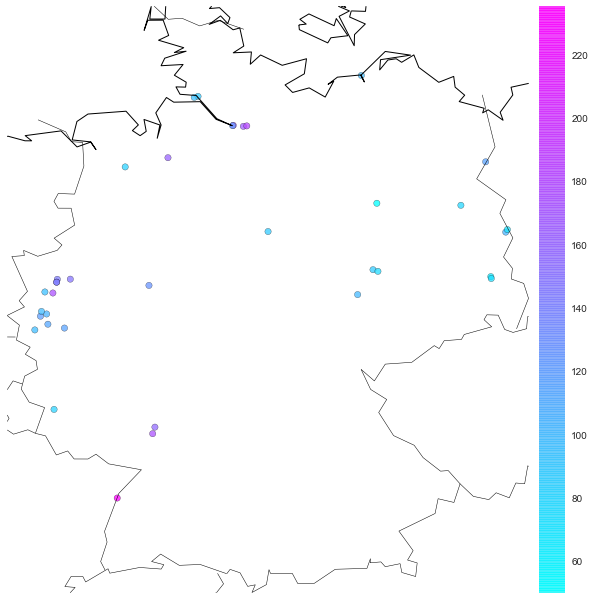

In [57]:
plot_map(worst_industry_stations, 'value')

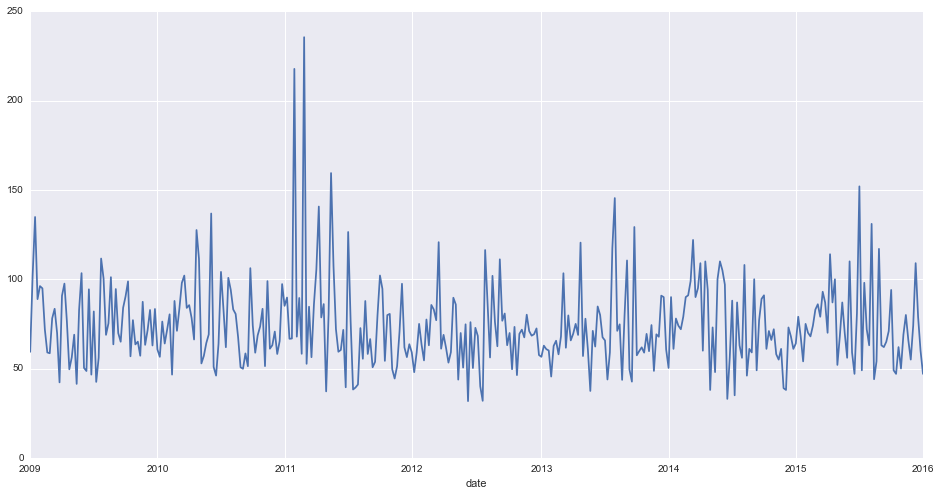

In [58]:
# Station in Kehl, maximal-Werte pro Woche
plt.figure(figsize=(16,8))
df[df.Station == 'DEBW022'].value.resample('1W', max).plot()

## Greenpeace-Aussagen

"Rund die Hälfte der bislang ausgewerteten 137 Luftmessstationen in Städten liefert im Neun-Monats-Mittel Daten, die den erlaubten Jahreswert von 40 Mikrogramm überschreiten." ([Quelle](https://www.greenpeace.de/themen/energiewende/fossile-energien/dicke-luft-deutschen-stadten))

In [59]:
# 245 Stationen mit Messungen in 2015 im städtischem Gebiet
city_data_2015 = df[(df.TYPE_OF_AREA == u'städtisches Gebiet') & (df.index.year == 2015)]
len(city_data_2015.groupby('Station'))

243

In [60]:
# 132 Stationen mit Messungen in 2015 im Städtischen Gebiet als Verkehrsstation
df_city_2015 = df[(df.TYPE_OF_AREA == u'städtisches Gebiet') & (df.TYPE_OF_STATION == 'Verkehr') & (df.index.year == 2015)].groupby('Station')
len(df_city_2015)

131

In [61]:
df_city_2015_station_values = df_city_2015.value.mean().dropna()
len(df_city_2015_station_values)

131

In [62]:
# Rund die Hälfte der Stationen überschreiten 40 im Mittel
len(df_city_2015_station_values[df_city_2015_station_values > 40])

69

Fazit: Zahlen können nicht genau rekonstruiert werden, Aussage stimmt aber.

### Gebiete

In [63]:
xl_file = pd.ExcelFile('data/gebiete.xlsx')
xl_file.sheet_names

[u'NO2_JMW_2010-2014',
 u'NO2_SMW_2010-2014',
 u'Legende',
 u'Gebiete mit Fristverl\xe4ngerung']

In [64]:
gebiete_df = xl_file.parse(u'NO2_JMW_2010-2014')
gebiete_df['lat'] = pd.to_numeric(gebiete_df['Breite'])
gebiete_df['lng'] = pd.to_numeric(gebiete_df[u'Länge'])
for c in range(2010, 2015):
    gebiete_df[c] = pd.to_numeric(gebiete_df[c], errors='coerce')
    gebiete_df[c][gebiete_df[c] < 0] = None
gebiete_df.head()

/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Stationscode                 Stationsname        Schadstoff Einheit  \
0      DEBB007                  Elsterwerda  Stickstoffdioxid   µg/m³   
1      DEBB021              Potsdam-Zentrum  Stickstoffdioxid   µg/m³   
2      DEBB029               Schwedt (Oder)  Stickstoffdioxid   µg/m³   
3      DEBB032             Eisenhüttenstadt  Stickstoffdioxid   µg/m³   
4      DEBB042  Frankfurt (Oder), 1997-2014  Stickstoffdioxid   µg/m³   

                       dataGroup     2010     2011     2012     2013     2014  \
0  halb- oder stündliche Messung  17.2986  15.2807  14.3334  14.4130  15.2192   
1  halb- oder stündliche Messung  20.3658  21.0117  18.6480  19.1359  19.1805   
2  halb- oder stündliche Messung  11.8610  12.0311  11.8490  10.9881  10.4217   
3  halb- oder stündliche Messung  14.0599  13.7264  13.4642  13.0830  11.4236   
4  halb- oder stündliche Messung  16.2638  14.0079  14.1344  13.3206      NaN   

   Gebietscode                                        Gebietsname  \
0  DEZAXX0009S  Kleinstädtischer und ländlicher Raum im Land B...   
1  DEZAXX0010S  Potsdam - Ort erhöhter verkehrsbedingter Schad...   
2  DEZAXX0008S  Kleinstädtischer und ländlicher Raum im Land B...   
3  DEZAXX0009S  Kleinstädtischer und ländlicher Raum im Land B...   
4  DEZAXX0012S  Frankfurt(O) - Ort erhöhter verkehrsbedingter ...   

   Einwohnerzahl TYPE_OF_STATION           TYPE_OF_AREA      Länge     Breite  \
0        1190878     Hintergrund  vorstädtisches Gebiet  13.526796  51.462734   
1         158902     Hintergrund     städtisches Gebiet  13.059945  52.401352   
2         875566       Industrie  vorstädtisches Gebiet  14.285139  53.064262   
3        1190878       Industrie  vorstädtisches Gebiet  14.638166  52.146264   
4          60002     Hintergrund  vorstädtisches Gebiet  14.531918  52.339953   

         lat        lng  
0  51.462734  13.526796  
1  52.401352  13.059945  
2  53.064262  14.285139  
3  52.146264  14.638166  
4  52.339953  14.531918

In [65]:
len(gebiete_df)

681

In [66]:
len(gebiete_df.groupby('Gebietscode'))

88

In [67]:
df_gc = df.reset_index().merge(gebiete_df[['Stationscode', 'Gebietscode']], left_on='Station', right_on='Stationscode', how='right')
df_gc.head()

date  Station        Komponente           TYPE_OF_AREA  \
0 2009-01-01 00:00:00  DEBB007  Stickstoffdioxid  vorstädtisches Gebiet   
1 2009-01-01 01:00:00  DEBB007  Stickstoffdioxid  vorstädtisches Gebiet   
2 2009-01-01 02:00:00  DEBB007  Stickstoffdioxid  vorstädtisches Gebiet   
3 2009-01-01 03:00:00  DEBB007  Stickstoffdioxid  vorstädtisches Gebiet   
4 2009-01-01 04:00:00  DEBB007  Stickstoffdioxid  vorstädtisches Gebiet   

  TYPE_OF_STATION TYPE_OF_DATA Lieferung  value Stationscode  Gebietscode  
0     Hintergrund            H         Y  23.20      DEBB007  DEZAXX0009S  
1     Hintergrund            H         Y  28.40      DEBB007  DEZAXX0009S  
2     Hintergrund            H         Y  27.65      DEBB007  DEZAXX0009S  
3     Hintergrund            H         Y  26.55      DEBB007  DEZAXX0009S  
4     Hintergrund            H         Y  25.70      DEBB007  DEZAXX0009S

In [68]:
gebiete_df.groupby('Gebietsname').size().sort_values(ascending=False).head(20)

Gebietsname
Essen                                                                  35
Urbane Bereiche und ländlicher Raum im Land Nordrhein-Westfalen        32
Köln                                                                   29
Ballungsraum Hamburg                                                   23
Regierungsbezirk Stuttgart (ohne Ballungsraum)                         20
Gebiet Thüringen 1                                                     20
Düsseldorf                                                             19
Gebiet III (Mittel- und Nordhessen)                                    19
Duisburg                                                               17
Ballungsraum I (Rhein-Main)                                            17
Ballungsraum Berlin                                                    16
Ballungsraum Stuttgart                                                 16
Dortmund                                                               14
Regierungsbezirk Tübingen 

In [69]:
# gebiete_df.groupby(['Gebietscode', 'Stationscode'])[2014].mean().unstack()
test_df = df[(df.index.year == 2015) & (df.index.month == 12)].reset_index()
test_df = test_df.pivot_table(values='value', index='date', columns='Station').resample('1W', how=np.mean).max(axis=1).reset_index().set_index('date')
# test_df = test_df.set_index('date').resample('1A')

In [70]:
test_df.as_matrix()[:, 0]

array([  93.71126761,  104.01829268,  105.71686747,   93.50363095,
         91.96808511])

In [71]:
df.head()

Station        Komponente           TYPE_OF_AREA TYPE_OF_STATION  \
date                                                                           
2009-01-01  DEBB007  Stickstoffdioxid  vorstädtisches Gebiet     Hintergrund   
2009-01-01  DEHE094  Stickstoffdioxid     städtisches Gebiet         Verkehr   
2009-01-01  DEHH008  Stickstoffdioxid     städtisches Gebiet     Hintergrund   
2009-01-01  DEHH015  Stickstoffdioxid     städtisches Gebiet       Industrie   
2009-01-01  DEHH016  Stickstoffdioxid     städtisches Gebiet       Industrie   

           TYPE_OF_DATA Lieferung  value  
date                                      
2009-01-01            H         Y  23.20  
2009-01-01            H         Y  38.00  
2009-01-01            H         Y  36.25  
2009-01-01            H         Y  30.50  
2009-01-01            H         Y    NaN

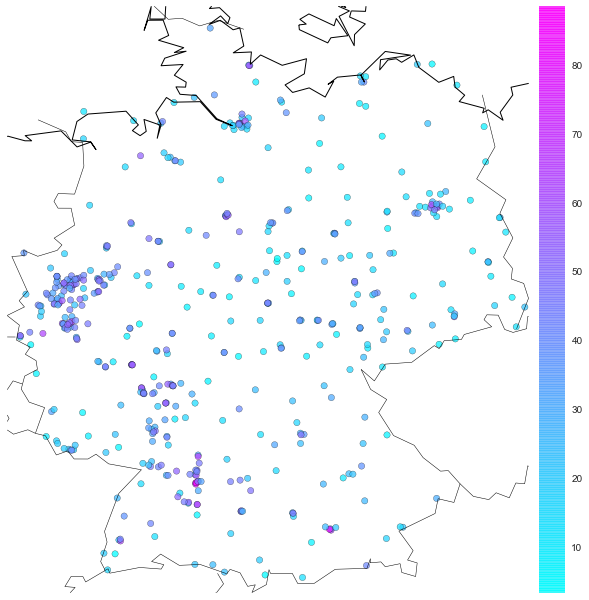

In [72]:
plot_map(gebiete_df, 2014)

In [73]:
len(set(stations['Station']))

1780

In [74]:
len(set(gebiete_df['Stationscode']))

658

In [75]:
len(set(stations['Station']) & set(gebiete_df['Stationscode']))

658

In [76]:
set(gebiete_df['Stationscode']) - set(stations['Station'])

set()

In [77]:
geojson_base = []

for code, g_df in gebiete_df.groupby('Gebietscode'):
    feature = {
      "type": "FeatureCollection",
      "properties": {"code": code},
      "features": []
    }
    for _, s in g_df.iterrows():
        feature['features'].append({
          "type": "Feature",
          "properties": {
                "code": s['Stationscode']
          },
          "geometry": {
            "type": "Point",
            "coordinates": [s['lng'], s['lat']]
          }
        })
    feature['properties']['name'] = s['Gebietsname']
    geojson_base.append(feature)
json.dump(geojson_base, open('gebiete.geojson', 'w'))

In [78]:
df_gc.set_index(['date', 'Gebietscode'])

Station        Komponente  \
date                Gebietscode                              
2009-01-01 00:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 01:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 02:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 03:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 04:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 05:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 06:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 07:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 08:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 09:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 10:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 11:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 12:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 13:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 14:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 15:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 16:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 17:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 18:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 19:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 20:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 21:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 22:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-01 23:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 00:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 01:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 02:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 03:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 04:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 05:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 06:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 07:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 08:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 09:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 10:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 11:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 12:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 13:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 14:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 15:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 16:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 17:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 18:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 19:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 20:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 21:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 22:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-02 23:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 00:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 01:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 02:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 03:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 04:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 05:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 06:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 07:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 08:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 09:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 10:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 11:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 12:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 13:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
2009-01-03 14:00:00 DEZAXX0009S  DEBB007  Stickstoffdioxid   
200

## Stationen über die Zeit

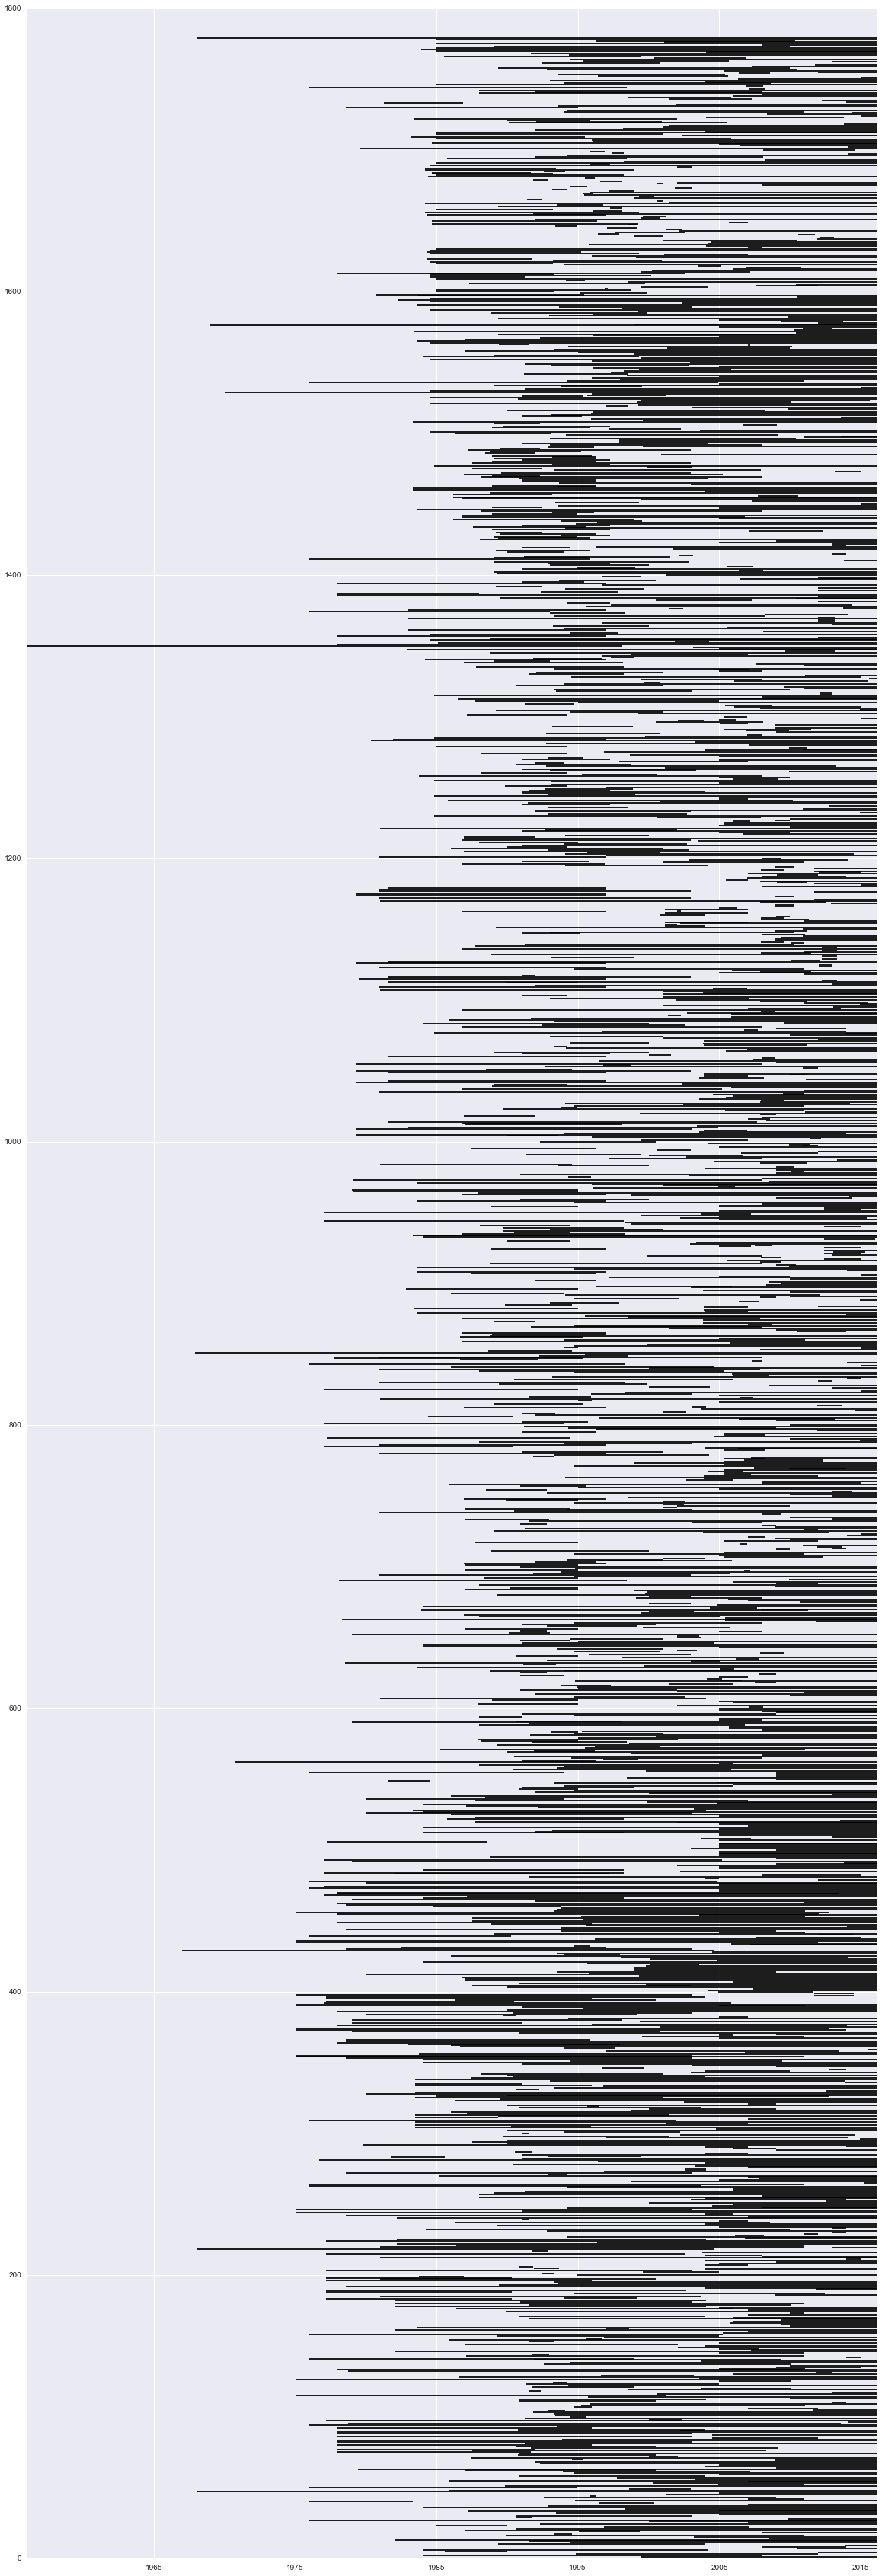

In [79]:
import matplotlib.dates as dt

fig = plt.figure(figsize=(20, 60))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()

ordered_stations = stations.sort_values(by=['lat', 'lng', u'Aktivitätsperiode: bis']).reset_index()
ordered_stations
ax = plt.hlines(ordered_stations.index, dt.date2num(ordered_stations[u'Aktivitätsperiode: von '].astype(datetime)),
                                dt.date2num(ordered_stations[u'Aktivitätsperiode: bis'].fillna(datetime.now().date()).astype(datetime)))

In [80]:
d = {}
for _, s in gebiete_df.Gebietscode.iteritems():
    d.setdefault(s, len(d))

In [81]:
gebiete_df['Gebietsnr'] = gebiete_df.Gebietscode.apply(lambda x: d[x])

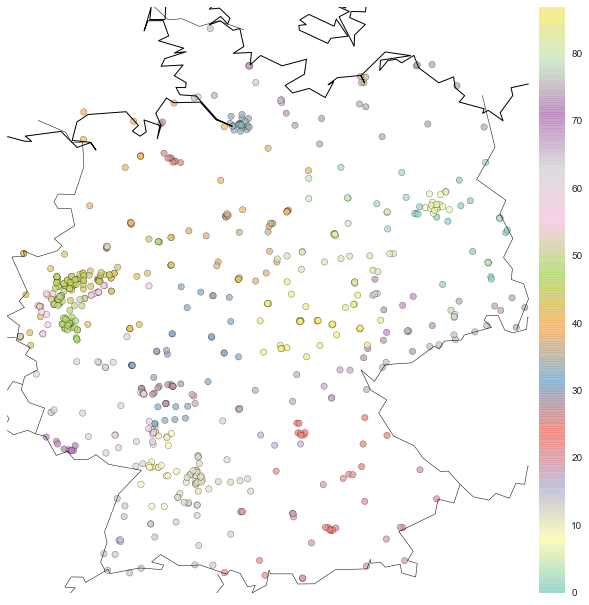

In [82]:
plot_map(gebiete_df, 'Gebietsnr', cmap='Set3')

In [83]:
from datetime import timedelta

a_year = timedelta(days=365)
# plot_map()
len(stations[stations[u'Aktivitätsperiode: bis'] - stations[u'Aktivitätsperiode: von '] < a_year])

54

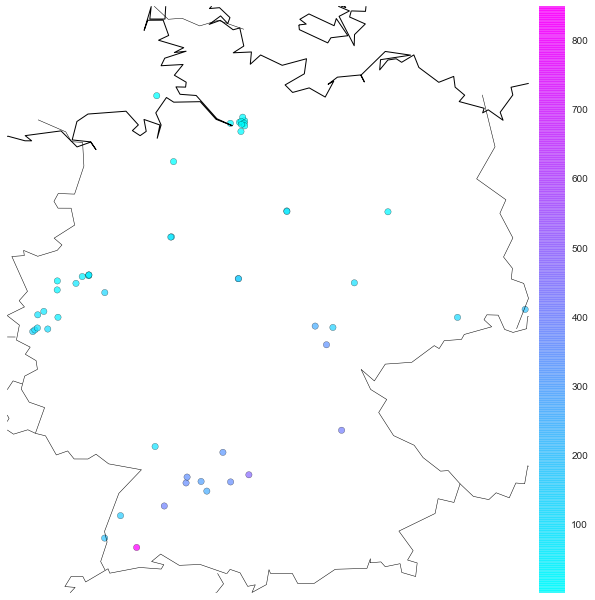

In [84]:
plot_map(stations[stations[u'Aktivitätsperiode: bis'] - stations[u'Aktivitätsperiode: von '] < a_year], u'Höhe')

In [85]:
stations['duration'] = (pd.to_datetime(stations[u'Aktivitätsperiode: bis'].fillna(datetime.now().date())) - 
                        stations[u'Aktivitätsperiode: von ']).astype(pd.Timedelta).apply(lambda l: l.days)

In [86]:
stations.duration.describe()

count     1780.000000
mean      4904.749438
std       3765.825872
min       -105.000000
25%       1827.750000
50%       4064.000000
75%       7482.250000
max      17610.000000
Name: duration, dtype: float64

In [87]:
stations.groupby('ballungsraum').duration.agg([np.mean, len])

mean  len
ballungsraum                         
Berlin               4272.313433   67
Freiburg             6396.500000    6
Hamburg              2953.873418   79
Karlsruhe            6297.625000    8
Mannheim/Heidelberg  7346.500000   10
Stuttgart            4889.296296   27

## Hamburg

In [91]:
hh_stations = stations[stations.Station.str.startswith('DEHH')]

(len(hh_stations), len(hh_stations[hh_stations.duration < a_year.days]),
                  len(hh_stations[hh_stations.duration < timedelta(days=7 * 52 * 2).days]),
                  len(hh_stations[hh_stations.duration < timedelta(days=7 * 52 * 3).days])
)

(80, 11, 31, 34)

In [92]:
'", "'.join(hh_stations.Station)

u'DEHH001", "DEHH002", "DEHH003", "DEHH004", "DEHH005", "DEHH006", "DEHH007", "DEHH008", "DEHH009", "DEHH010", "DEHH011", "DEHH012", "DEHH013", "DEHH014", "DEHH015", "DEHH016", "DEHH017", "DEHH018", "DEHH019", "DEHH020", "DEHH021", "DEHH022", "DEHH023", "DEHH024", "DEHH025", "DEHH026", "DEHH027", "DEHH028", "DEHH029", "DEHH030", "DEHH031", "DEHH032", "DEHH033", "DEHH034", "DEHH035", "DEHH036", "DEHH037", "DEHH038", "DEHH039", "DEHH040", "DEHH041", "DEHH042", "DEHH043", "DEHH044", "DEHH045", "DEHH046", "DEHH047", "DEHH048", "DEHH049", "DEHH050", "DEHH051", "DEHH052", "DEHH053", "DEHH054", "DEHH055", "DEHH056", "DEHH057", "DEHH058", "DEHH059", "DEHH060", "DEHH061", "DEHH062", "DEHH063", "DEHH064", "DEHH065", "DEHH066", "DEHH067", "DEHH068", "DEHH069", "DEHH070", "DEHH071", "DEHH072", "DEHH073", "DEHH074", "DEHH075", "DEHH076", "DEHH077", "DEHH078", "DEHH079", "DEHH080'

In [93]:
hh_stations.duration.describe()

count       80.000000
mean      2921.900000
std       3013.779114
min        -24.000000
25%        459.250000
50%       1795.000000
75%       4883.750000
max      11675.000000
Name: duration, dtype: float64

In [94]:
hh_stations['Verlegt'].value_counts()

nein    74
Name: Verlegt, dtype: int64

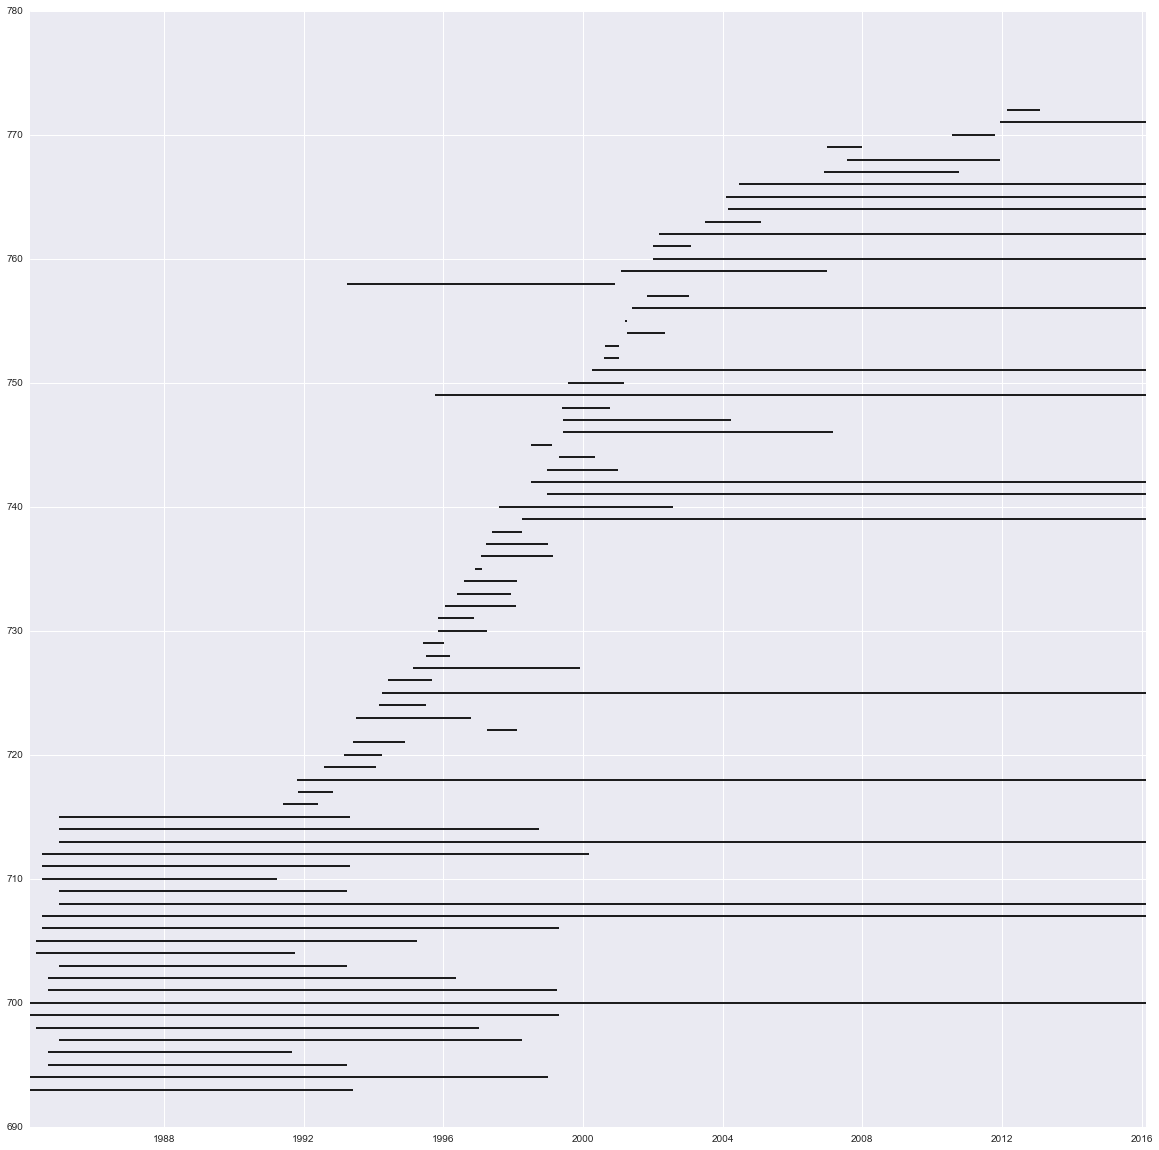

In [95]:
import matplotlib.dates as dt

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()

ax = plt.hlines(hh_stations.index, dt.date2num(hh_stations[u'Aktivitätsperiode: von '].astype(datetime)),
                                dt.date2num(hh_stations[u'Aktivitätsperiode: bis'].fillna(datetime.now().date()).astype(datetime)))

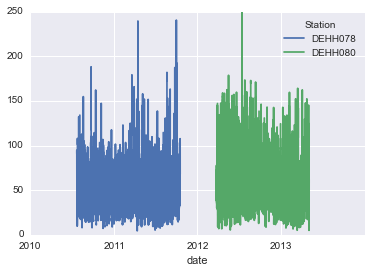

In [98]:
df[df.Station.isin(list(hh_stations[hh_stations.duration < timedelta(days=7 * 52 * 3).days].Station))].reset_index().set_index(['date', 'Station']).value.unstack().plot()

In [99]:
df[df.Station == u'DEHH078'].value.describe()

count    9753.000000
mean       51.662714
std        24.089680
min         4.450000
25%        34.550000
50%        48.750000
75%        64.650000
max       240.450000
Name: value, dtype: float64

In [100]:
hh_df_1 = df[(df.Station == u'DEHH078') & (df.value > 200)]
hh_df_1.groupby(hh_df_1.index.year).count()

Station  Komponente  TYPE_OF_AREA  TYPE_OF_STATION  TYPE_OF_DATA  \
2011        4           4             4                4             4   

      Lieferung  value  
2011          4      4

In [101]:
hh_df_2 = df[(df.Station == u'DEHH080') & (df.value > 200)]
hh_df_2.groupby(hh_df_2.index.year).count()

Station  Komponente  TYPE_OF_AREA  TYPE_OF_STATION  TYPE_OF_DATA  \
2012        1           1             1                1             1   

      Lieferung  value  
2012          1      1

In [102]:
hh_df = df[df.Station.str.startswith('DEHH')].reset_index()

In [103]:
exceeding_200 = lambda x: np.sum(x > 200)

hh_df.pivot_table(index=['Station', hh_df.date.dt.year], values=['value'], aggfunc={'value': [np.mean, exceeding_200]})

value         
                   mean <lambda>
Station date                    
DEHH008 2009  29.490240        0
        2010  29.460528        0
        2011  30.280654        0
        2012  30.084895        0
        2013  27.653451        0
        2014  27.111743        0
        2015  26.878279        0
DEHH015 2009  37.087870        0
        2010  38.062598        0
        2011  36.151626        0
        2012  36.508745        0
        2013  35.869839        0
        2014  34.678444        0
        2015  33.763723        0
DEHH016 2009  27.674190        0
        2010  26.087277        0
        2011  25.042355        0
        2012  25.564371        0
        2013  25.747169        0
        2014  24.113524        0
        2015  25.109740        0
DEHH021 2009  15.695291        0
        2010  17.288983        0
        2011  15.960523        0
        2012  16.675969        0
        2013  16.816664        0
        2014  15.037708        0
        2015  15.161014        0
DEHH026 2009  63.034724        8
        2010  66.235003        1
        2011  61.064762        5
        2012  57.029515        1
        2013  57.798325        5
        2014  54.154840        1
        2015  49.376539        0
DEHH033 2009  22.028353        0
        2010  21.776342        0
        2011  22.938022        0
        2012  23.413417        0
        2013  22.264610        0
        2014  21.795396        0
        2015  21.395571        0
DEHH047 2009  17.197888        0
        2010  17.598817        0
        2011  17.057500        0
        2012  17.856292        0
        2013  15.996880        0
        2014  16.774228        0
        2015  16.706974        0
DEHH049 2009  16.725267        0
        2010  17.970766        0
        2011  17.428115        0
        2012  17.219908        0
        2013  16.312127        0
        2014  17.327401        0
        2015  16.115795        0
DEHH050 2009  15.788653        0
        2010  15.996191        0
        2011  15.287689        0
        2012  14.974501        0
        2013  15.500390        0
        2014  14.990618        0
        2015  13.467956        0
DEHH059 2009  26.099572        0
        2010  29.827447        0
        2011  28.227747        0
        2012  28.546454        0
        2013  26.818417        0
        2014  25.621697        0
        2015  26.136829        0
DEHH064 2009  53.658284        0
        2010  53.424583        1
        2011  51.213858        2
        2012  49.622947        0
        2013  45.119802        0
        2014  46.061831        0
        2015  48.174256        0
DEHH068 2009  62.313653       28
        2010  59.530197       21
        2011  61.277058       11
        2012  63.834243        3
        2013  56.766615        5
        2014  58.231502       12
        2015  62.880004        7
DEHH070 2009  71.202086        2
        2010  70.000013       12
        2011  67.264223        4
        2012  65.180572        1
        2013  62.860403        1
        2014  61.623688        0
        2015  61.886373        3
DEHH072 2009  20.600471        0
        2010  21.530654        0
        2011  20.259969        0
        2012  19.482205        0
        2013  19.494400        0
        2014  19.512683        0
        2015  17.998999        0
DEHH073 2009  18.663216        0
        2010  19.775211        0
        2011  18.547605        0
        2012  18.668613        0
        2013  18.669546        0
        2014  18.823303        0
        2015  16.578635        0
DEHH074 2009  30.717489        0
        2010  31.665976        0
        2011  33.134106        0
        2012  34.097784        0
        2013  31.975698        0
        2014  30.328761        0
        2015  31.121442        0
DEHH075 2009  24.717941        0
        2010  27.459060        0
DEHH076 2009  26.047022        0
        2010  27.356083        0
        2011  26.418769        0
DEHH078 2010  50.484848        0
        2011  52.289959  

In [104]:
stations[stations.Station.isin(['DEHH080', 'DEHH078', 'DEHH081'])]

Station                         Stationsname        Kategorie Synonym  \
770  DEHH078  Hamburg Simon-von-Utrecht-Straße 66  Luftmessstation    79SU   
772  DEHH080          Hamburg Willy-Brandt-Straße  Luftmessstation    81WT   

    Aktiv seit  Aktivitätsperiode: von  Aktivitätsperiode: bis Verlegt  \
770  2010-07-23              2010-07-23             2011-10-17    nein   
772  2012-02-27              2012-02-27             2013-02-05     NaN   

                       Straße  Nr    PLZ      Ort Länge dezimal  \
770  Simon-von-Utrecht-Straße  66  20359  Hamburg      9,965585   
772       Willy-Brandt-Straße  73  20459  Hamburg      9,987920   

    Breite dezimal  Höhe Stationsumgebung (EoI) Art der Station (EoI)  \
770      53,551042    16     städtisches Gebiet               Verkehr   
772      53,547355     5     städtisches Gebiet               Verkehr   

     Einwohnerzahl (EoI) Abstand zur Straße (EoI) Bemerkung (EoI)  \
770                  NaN                  >1-10 m             NaN   
772                  NaN                  >1-10 m             NaN   

    Lokaler Code EMEP-Code O3-Klasse aus UBA FE NO/NO2-Klasse aus UBA FE  \
770         79SU       NaN                  NaN                      NaN   
772         81WT       NaN                  NaN                      NaN   

    Bemerkung des UBA(1) Bemerkung des UBA(2) Bemerkung des Netzbetreibers  \
770                  NaN                  NaN                          NaN   
772                  NaN                  NaN                          NaN   

    AEI-Station AEI-von AEI-bis ersetzt AEI-Station  \
770        nein     NaN     NaN                 NaN   
772        nein     NaN     NaN                 NaN   

     Amtlicher Gemeindeschlüssel (AGS) Gemeindenamen  \
770                            2000000       Hamburg   
772                            2000000       Hamburg   

     Entfernung von einer verkehrsreichen Kreuzung in Metern  \
770                                                240         
772                                                103         

     Geschätztes Verkehrsaufkommen (Anzahl der Fahrzeuge pro Tag)  \
770                                              16000              
772                                              59000              

     Waagrechte Entfernung vom nächsten Gebäude in Metern  \
770                                                  4      
772                                                 11      

     Entfernung von der nächsten Straße in Metern  \
770                                            35   
772                                            50   

     Entfernung von der wichtigsten Industriequelle in Metern  \
770                                                NaN          
772                                                NaN          

    Quelle 1 (Hauptquelle) Quelle 1 (Hauptquelle) - ID Gasförmige Schadstoffe  \
770          Verkehr (1A3)                         1A3                    1,5   
772          Verkehr (1A3)                         1A3                    1,5   

    Partikelförmige Schadstoffe Deposition Umweltmonitoring-Typ  Unnamed: 44  \
770                         3,5        NaN                 k.A.          NaN   
772                         3,5        NaN                 k.A.          NaN   

          lng        lat  height    ags gemeinde ballungsraum  duration  
770  9.965585  53.551042      16  20000  Hamburg      Hamburg       451  
772  9.987920  53.547355       5  20000  Hamburg      Hamburg       344

In [105]:
stations[stations.Stationsname.str.contains('Max-Brauer')]

Station                          Stationsname        Kategorie Synonym  \
740  DEHH048          HH Max-Brauer-Allee (Straße)  Luftmessstation    50MB   
762  DEHH070  Hamburg Max-Brauer-Allee II (Straße)  Luftmessstation    70MB   

    Aktiv seit  Aktivitätsperiode: von  Aktivitätsperiode: bis Verlegt  \
740  1997-08-01              1997-08-01             2002-08-02    nein   
762  2002-03-01              2002-03-01                    NaT    nein   

               Straße     Nr    PLZ      Ort Länge dezimal Breite dezimal  \
740  Max-Brauer-Allee     87  22765  Hamburg      9,942706      53,555491   
762  Max-Brauer-Allee  92/94  22765  Hamburg      9,943012      53,555668   

     Höhe Stationsumgebung (EoI) Art der Station (EoI)  Einwohnerzahl (EoI)  \
740    25     städtisches Gebiet               Verkehr                  NaN   
762    25     städtisches Gebiet               Verkehr                  NaN   

    Abstand zur Straße (EoI)  \
740           direkt (0-1 m)   
762                  >1-10 m   

                                       Bemerkung (EoI) Lokaler Code EMEP-Code  \
740  Die Station wurde zuvor als Max-Brauer-Allee1 ...         50MB        No   
762                                                NaN         70MB       NaN   

    O3-Klasse aus UBA FE NO/NO2-Klasse aus UBA FE  \
740                  NaN                       VK   
762                  NaN                      NaN   

                                  Bemerkung des UBA(1) Bemerkung des UBA(2)  \
740  Mittelstreifen der Max-Brauer-Allee, bei Haus ...                  NaN   
762                                                NaN                  NaN   

                   Bemerkung des Netzbetreibers AEI-Station AEI-von AEI-bis  \
740  verlegt nach Max-Brauer-Allee II (DEHH070)        nein     NaN     NaN   
762                                         NaN        nein     NaN     NaN   

    ersetzt AEI-Station  Amtlicher Gemeindeschlüssel (AGS) Gemeindenamen  \
740                 NaN                            2000000       Hamburg   
762                 NaN                            2000000       Hamburg   

     Entfernung von einer verkehrsreichen Kreuzung in Metern  \
740                                                NaN         
762                                                 80         

     Geschätztes Verkehrsaufkommen (Anzahl der Fahrzeuge pro Tag)  \
740                                                NaN              
762                                              29000              

     Waagrechte Entfernung vom nächsten Gebäude in Metern  \
740                                                NaN      
762                                                 14      

     Entfernung von der nächsten Straße in Metern  \
740                                           NaN   
762                                            70   

     Entfernung von der wichtigsten Industriequelle in Metern  \
740                                                NaN          
762                                                NaN          

    Quelle 1 (Hauptquelle) Quelle 1 (Hauptquelle) - ID Gasförmige Schadstoffe  \
740          Verkehr (1A3)                         1A3                    3,5   
762          Verkehr (1A3)                         1A3                    1,5   

    Partikelförmige Schadstoffe Deposition Umweltmonitoring-Typ  Unnamed: 44  \
740                         3,5        NaN                 k.A.          NaN   
762                         3,5        NaN                 k.A.          NaN   

          lng        lat  height    ags gemeinde ballungsraum  duration  
740  9.942706  53.555491      25  20000  Hamburg      Hamburg      1827  
762  9.943012  53.555668      25  20000  Hamburg      Hamburg      5101

In [106]:
df[df.Station.str.startswith('DEHH')].Station.value_counts()

DEHH064    61344
DEHH026    61344
DEHH059    61344
DEHH008    61344
DEHH074    61344
DEHH068    61344
DEHH073    61344
DEHH072    61344
DEHH070    61344
DEHH021    61344
DEHH016    61344
DEHH015    61344
DEHH047    61344
DEHH049    61344
DEHH033    61344
DEHH050    61344
DEHH079    43824
DEHH076    26280
DEHH080    17544
DEHH075    17520
DEHH078    17520
DEHH081     2208
Name: Station, dtype: int64

In [108]:
stations[stations.duration < 0]

Station        Stationsname        Kategorie Synonym Aktiv seit   \
755   DEHH063          HH Neuwerk  Luftmessstation    65NW  2001-04-05   
1058  DENW128  Castrop-Rauxel (7)  Luftmessstation     NaN  2002-04-23   
1668  DETH052   Jena Prüssingstr.  Luftmessstation     NaN  1993-05-05   

     Aktivitätsperiode: von  Aktivitätsperiode: bis Verlegt          Straße  \
755               2001-04-05             2001-03-12    nein    Am Mittelweg   
1058              2002-04-23             2002-01-08     NaN  Wartburgstraße   
1668              1993-05-05             1993-04-10    nein    Prüssingstr.   

       Nr    PLZ              Ort Länge dezimal Breite dezimal  Höhe  \
755   NaN  27499  Hamburg Neuwerk      8,497442      53,917866     1   
1058  105  44579   Castrop-Rauxel      7,303315      51,582374    58   
1668   25   7745             Jena     11,597089      50,884216   148   

     Stationsumgebung (EoI) Art der Station (EoI)  Einwohnerzahl (EoI)  \
755      ländlich abgelegen           Hintergrund                  NaN   
1058  vorstädtisches Gebiet             Industrie                  NaN   
1668  vorstädtisches Gebiet           Hintergrund                  NaN   

     Abstand zur Straße (EoI)     Bemerkung (EoI) Lokaler Code EMEP-Code  \
755                   >1-10 m  an Feldweg gelegen         65NW       NaN   
1058                      NaN                 NaN        CARA7       NaN   
1668                >50-100 m                 NaN           31       NaN   

     O3-Klasse aus UBA FE NO/NO2-Klasse aus UBA FE       Bemerkung des UBA(1)  \
755                   NaN                      NaN                        NaN   
1058                  NaN                      NaN                        NaN   
1668                  NaN                      NaN  Prüssingstr. 25, nur Ozon   

     Bemerkung des UBA(2) Bemerkung des Netzbetreibers AEI-Station AEI-von  \
755                   NaN                          NaN        nein     NaN   
1058                  NaN                          NaN        nein     NaN   
1668                  NaN               nur Ozon(Haus)        nein     NaN   

     AEI-bis ersetzt AEI-Station  Amtlicher Gemeindeschlüssel (AGS)  \
755      NaN                 NaN                            2000000   
1058     NaN                 NaN                            5562004   
1668     NaN                 NaN                           16053000   

       Gemeindenamen  Entfernung von einer verkehrsreichen Kreuzung in Metern  \
755          Hamburg                                                NaN         
1058  Castrop-Rauxel                                                NaN         
1668            Jena                                                NaN         

      Geschätztes Verkehrsaufkommen (Anzahl der Fahrzeuge pro Tag)  \
755                                                 NaN              
1058                                                NaN              
1668                                                NaN              

      Waagrechte Entfernung vom nächsten Gebäude in Metern  \
755                                                 NaN      
1058                                                NaN      
1668                                                NaN      

      Entfernung von der nächsten Straße in Metern  \
755                                            NaN   
1058                                           NaN   
1668                                           NaN   

      Entfernung von der wichtigsten Industriequelle in Metern  \
755                                                 NaN          
1058                                                300          
1668                                                NaN          

     Quelle 1 (Hauptquelle) Quelle 1 (Hauptquelle) - ID  \
755   keine Emissionen (no)                          no   
1058  Industrieprozesse (2)                           2   
1668  keine Emissionen (no)                          no   

    